In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
epochs = 10
lr = 1e-3

def get_data(training_data, test_data):
    return (
        DataLoader(training_data), #, shuffle=True),
        DataLoader(test_data),
    )

train_dl, valid_dl = get_data(training_data, test_data)
train_dataloader = DataLoader(training_data, batch_size=1)
test_dataloader = DataLoader(test_data, batch_size=1)

Using cpu device


In [12]:
x1,y1 = next(iter(train_dl))
x1, y1 =x1.flatten(), y1.squeeze()
x1.shape, y1.shape

(torch.Size([784]), torch.Size([]))

In [13]:
state_dict = torch.load('model.pth')
state_dict.keys()
weights = []
weights.append(state_dict['linear_relu_stack.0.weight'].clone())
weights.append(state_dict['linear_relu_stack.2.weight'].clone())
bias = []
bias.append(state_dict['linear_relu_stack.0.bias'].clone())
bias.append(state_dict['linear_relu_stack.2.bias'].clone())

In [14]:
def relu(X):
    X[X<0] = 0
    return X

def d_relu(x):
    d = x.clone()
    d[x < 0] = 0
    d[x > 0] = 1
    return d

def linear(x):
    return x

def softmax(x):
    return x.exp() / x.exp().sum()

def delta_l(y_pred, y, l):
    if l == len(weights)-1: # This means it's the last layer... must be a vector
        y_ = torch.zeros(len(y_pred))
        y_[y] = 1
        return (y_pred - y_)[None,:]
    else:
        return (weights[l+1].T@delta_l(y_pred,y,l+1).T)@d_relu(l)
        # return weights[l].T@(delta_l(y_pred,y,l+1)*d_relu(l+1)).T
    
activations = []
activations.append(relu)
activations.append(linear)
    
def forward(X):
    a = [X]
    
    for w,b,func in zip(weights, bias, activations):
        a.append(func(a[-1]@w.T+b))
    return a

def cross_entropy(y_pred,y):
    return -y_pred[y].log()

def backward(a,y, lr=1e-3): # hard-wired backprop...
    loss_L = delta_l(a[-1],y,1)
    loss_l = ((weights[1].T@loss_L.T).T*d_relu(a[1]))
    
    weights[1] -= lr * (a[1][None,:].T@loss_L).T
    bias[1] -= lr * loss_L.squeeze()
    weights[0] -= lr * (a[0][None,:].T@loss_l).T
    bias[0] -= lr * loss_l.squeeze()
        
    loss = cross_entropy(a[-1],y)
    return loss


In [15]:
a = None
w,b,func = _,_,_
y_pred = None
X=None
d=Nonel=None

<Axes: >

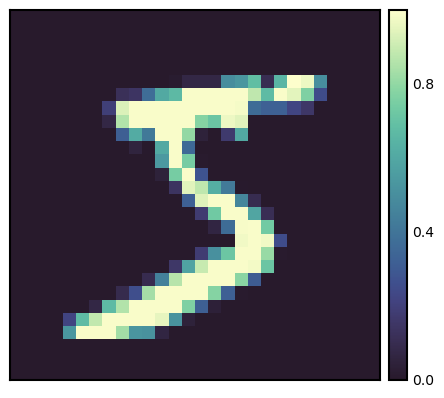

In [16]:
import seaborn_image as isns
isns.imgplot(x1.reshape(28,28))

### Test the full training 

In [17]:
x,y = next(iter(train_dataloader))
x,y = x.flatten(), y.squeeze()

In [18]:
time_dist = np.zeros(10000)

In [19]:
def train(dataloader):
    correct = 0
    size = len(dataloader.dataset)
    for i, (x,y) in enumerate(dataloader):
        x,y = x.flatten(), y.squeeze()
        start = time.time()
        a = forward(x)
        finish = time.time()
        time_dist[i] = finish - start
        a[-1] = softmax(a[-1])
        loss = cross_entropy(a[-1],y)

        backward(a,y)

        correct += (a[-1].argmax() == y).type(torch.float).sum()

        if i % 10000 == 0:
            loss, current = loss.item(), (i+1)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        # if i == 100:
        #     break;
        
    correct /= size
    print(f"Training Error: \n Accuracy: {(100*correct):>0.5f}%")

        

In [20]:
def test(dataloader):
    correct = 0
    test_loss = 0
    for i,(x,y) in enumerate(dataloader):
        x,y = x.flatten(), y.squeeze()
        start = time.perf_counter()
        a = forward(x)
        finish = time.perf_counter()
        time_dist[i] = finish - start
        test_loss += cross_entropy(softmax(a[-1]),y)
        correct += (a[-1].argmax() == y).type(torch.float).sum()

    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [21]:
start = time.time()
test(test_dataloader)
finish = time.time()
print(finish - start)

Test Error: 
 Accuracy: 11.9%, Avg loss: 2.330891 

2.9354891777038574


In [22]:
print(f"Median compute time: {np.median(time_dist)*1000000000} (ns), Mean compute time: {np.mean(time_dist)*1000000000} (ns)")# measures time in nanoseconds

Median compute time: 59600.00044069602 (ns), Mean compute time: 63847.209997584294 (ns)


In [26]:
np.std(time_dist)*100000000

19720.84523258466

In [71]:
time_dist[0] *1000000000

181500.00141758937

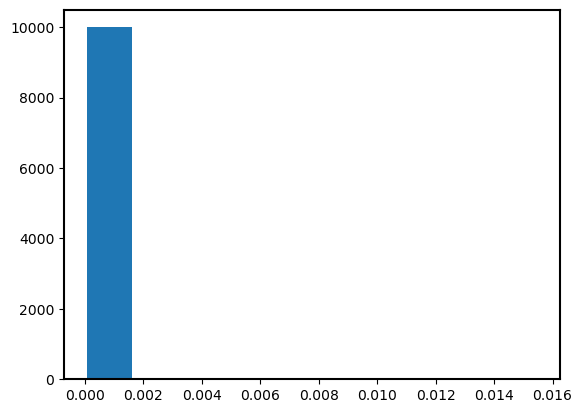

In [45]:
plt.figure()
plt.hist(time_dist)
plt.show()

In [2]:
x = [33600, 34400, 33100, 32999, 33000, 32901, 33099, 32900, 33001, 33000, 33099, 33100, 32900, 33200, 32900, 33099, 33000, 33001, 33301, 33200, 33000, 32900, 33500, 32900, 33101, 33101, 33001, 33100, 32900, 32900, 33001, 33000, 33100, 33299, 32899, 32900, 36701, 33000, 34201, 33000, 32901, 33101, 32900, 33000, 32901, 33100, 33001, 33100, 33200, 34800, 33001, 32901, 33100, 34300, 33101, 32800, 33001, 32901, 34701, 32900, 30100, 30000, 30000, 30100, 30100, 30000, 30100, 30499, 30100, 38100, 48300, 45400, 30001, 30000, 31800, 30100, 30000, 30100, 30000, 30100, 30100, 30000, 30001, 31500, 30000, 30100, 30000, 30200, 30000, 30100, 30001, 30000, 30300, 30100, 30200, 30100, 31401, 30100, 30100, 30000, 30000, 33699, 33000, 33200, 33200, 32899, 33000, 33400, 32999, 32999, 33100, 34999, 33200, 32999, 33000, 32900, 33000, 32999, 33200, 32900, 34399, 32900, 32900, 41201, 45899, 44300, 40000, 36299, 33500, 33300, 33100, 33300, 33400, 33101, 33400, 32900, 37799, 33400, 33200, 33100, 35701, 33200, 33100, 34000, 33600, 33299, 33299, 34001, 34100, 37601, 33800, 33301, 33300, 34800, 33101, 33099, 33100, 35100, 33000, 33001, 33199, 33200, 35100, 33500, 33500, 33700, 33300, 33701, 33600, 33301, 33601, 34199, 33100, 33200, 33101, 32200, 33900, 44300, 34100, 55100, 34400, 33300, 33599, 30401, 33100, 48500, 32401, 30500, 33301, 33500, 35000, 32000, 30900, 53800, 33700, 33600, 33900, 30800, 30699, 30600, 30800, 35601, 33500, 33100, 33300, 32999, 32900, 33000, 35100, 32899, 33200, 32900, 32900, 33100, 33000, 33099, 33000, 35000, 33100, 32900, 32900, 32900, 33000, 33000, 33200, 33099, 33200, 32999, 32900, 32900, 35100, 33101, 33001, 33000, 32899, 32999, 32900, 32901, 33100, 34600, 33100, 32999, 33000, 32800, 34400, 33000, 33301, 32900, 32999, 33100, 33000, 32899, 34700, 33000, 33101, 32801, 33101, 33201, 32900, 30200, 30100, 32300, 30100, 30000, 29999, 30100, 30201, 29999, 30100, 29900, 30100, 30001, 30100, 29900, 31500, 31500, 30300, 30200, 30100, 30100, 30000, 30100, 30100, 31500, 29900, 30001, 30000, 30000, 30200, 30000, 30100, 30100, 33400, 48000, 44900, 30100, 30000, 30001, 29900, 30000, 33800, 35200, 30200, 33900, 30299, 30100, 30100, 29900, 30200, 30000, 58600, 41100, 33900, 42301, 41100, 44201, 30100, 48800, 33300, 35600, 33401, 33699, 33600, 35900, 33801, 33700, 33800, 33101, 34200, 54201, 55900, 53201, 33101, 37401, 45600, 30200, 53401, 68000, 53600, 34100, 33900, 33500, 32700, 32000, 103999, 72900, 32000, 32000, 30600, 30401, 30800, 33000, 31200, 30400, 30100, 30800, 30500, 30600, 31099, 30400, 36399, 45500, 30200, 30000, 47499, 41901, 36801, 30100, 30800, 30001, 29900, 30199, 31599, 29999, 30000, 30100, 30000, 30200, 29999, 30000, 30100, 31500, 29999, 30001, 30400, 30100, 29999, 30000, 30201, 30200, 32000, 30100, 30200, 29999, 31500, 30001, 30000, 30100, 30001, 30201, 30601, 34100, 33100, 36200, 33100, 32899, 32899, 33001, 33000, 33000, 32901, 32900, 33000, 33101, 33000, 33101, 34600, 32901, 32800, 32900, 32901, 32900, 32900, 33099, 32901, 34501, 32900, 33001, 32900, 33099, 32999, 32900, 32999, 32900, 32899, 32900, 32900, 32900, 34400, 33100, 33299, 32900, 32800, 33100, 33200, 33099, 32900, 34500, 33200, 32800, 32801, 32901, 32901, 33100, 33000, 32999, 32999, 32999, 32900, 33101, 34600, 33000, 33200, 32799, 32901, 33000, 32900, 33000, 32900, 34600, 32899, 32900, 32901, 33200, 33100, 32799, 32901, 32899, 32900, 33400, 33100, 33100, 34600, 33000, 33200, 32901, 32900, 33100, 33001, 33000, 32901, 34700, 32899, 32900, 32800, 32900, 33101, 32900, 33000, 33000, 36500, 36199, 33400, 33200, 33000, 33100, 33200, 36000, 33401, 33300, 33099, 33100, 33200, 33400, 33299, 34200, 35100, 39300, 33799, 34000, 33900, 33800, 45100, 33300, 33200, 33200, 33600, 35900, 33500, 33499, 33700, 33200, 36700, 106700, 34300, 35500, 35800, 61700, 33800, 34999, 33301, 33900, 33200, 33900, 33500, 33300, 33401, 35801, 33500, 33300, 33700, 34101, 34701, 33400, 32899, 32900, 44699, 43600, 36901, 33400, 33100, 33101, 32801, 33000, 34700, 33000, 32900, 33099, 32999, 32999, 33200, 32801, 32899, 33100, 32900, 32900, 32900, 34499, 33200, 32900, 33000, 32900, 33000, 33200, 32900, 32900, 34600, 33001, 32899, 32900, 32900, 33099, 33200, 32900, 33000, 33000, 33000, 32801, 32901, 34700, 33000, 33600, 33500, 33101, 32900, 33001, 33000, 33001, 35700, 33099, 33000, 33100, 32999, 32900, 33100, 32999, 32901, 32901, 33000, 32899, 33000, 32900, 33001, 35100, 32899, 32900, 32900, 32901, 33000, 32900, 33200, 32799, 33100, 32900, 33000, 33000, 32900, 32899, 37999, 33400, 33200, 32999, 33100, 33000, 32900, 33001, 32799, 33000, 32900, 32899, 32999, 33000, 33300, 33100, 32901, 32900, 32999, 32900, 32901, 33001, 33000, 32899, 32999, 32900, 32901, 33100, 33000, 32899, 33000, 32899, 33100, 32900, 33000, 32900, 32801, 33100, 32900, 33001, 32900, 32901, 33000, 35301, 33000, 33000, 32900, 32900, 36799, 34000, 43400, 33100, 60801, 33500, 37700, 33401, 33200, 33300, 33300, 33299, 33700, 32901, 33200, 38600, 30400, 30199, 30100, 30000, 30201, 30099, 30001, 30000, 31900, 30100, 30100, 30300, 49799, 33900, 33499, 67200, 32999, 34400, 33700, 33599, 33700, 36300, 34200, 33700, 33600, 50700, 44899, 33100, 33201, 34000, 43800, 30999, 70900, 45799, 31801, 30401, 32000, 32101, 35699, 33500, 34100, 30899, 58499, 31600, 30800, 31200, 34399, 30999, 30600, 30299, 31001, 30800, 30399, 45800, 30200, 31000, 30399, 30899, 50300, 35300, 30100, 30200, 31501, 40500, 39701, 35300, 31000, 36800, 51000, 51100, 30000, 30100, 30100, 29900, 30100, 30000, 30000, 30001, 30000, 30100, 31600, 30100, 30200, 30100, 29900, 29900, 30000, 33101, 33200, 34600, 33001, 33000, 32800, 33100, 33000, 32900, 32901, 32900, 33000, 35001, 33000, 33100, 33100, 33100, 32900, 35600, 33300, 33000, 33100, 32901, 33001, 33400, 32900, 32801, 32999, 33100, 33199, 32899, 32900, 32801, 34900, 33200, 33000, 32999, 33100, 33201, 32900, 32999, 33000, 32901, 33200, 32901, 33200, 32801, 36900, 34300, 33000, 33001, 32800, 32899, 32899, 33100, 32901, 34801, 33100, 32899, 32799, 32900, 33001, 33000, 34200, 33101, 34701, 33300, 32900, 33100, 34600, 33001, 32800, 32900, 32999, 33001, 33100, 33200, 33001, 100200, 61700, 33400, 34000, 35800, 33000, 33100, 33300, 33000, 33000, 33100, 32900, 33100, 32899, 33599, 32999, 33100, 32999, 32900, 32800, 32800, 33000, 32901, 59700, 33400, 33101, 33000, 33200, 33400, 33800, 32901, 33200, 33699, 33500, 39800, 33600, 33199, 33400, 37299, 33799, 33900, 33100, 33700, 34301, 35100, 37100, 33500, 34300, 33900, 34101, 33900, 36199, 34600, 33900, 33200, 48600, 36300, 37700, 38801, 38799, 52300, 34500, 34001, 37500, 33499, 34501, 33700, 35500, 34000, 33900, 34700, 33900, 34200, 33600, 34001, 34100, 36599, 33400, 32999, 50100, 52601, 34400, 33300, 33599, 35100, 33100, 33000, 33200, 33000, 33000, 33301, 32900, 32901, 32999, 33000, 33200, 33000, 34500, 33100, 32899, 33000, 32900, 33000, 33100, 33200, 33200, 34700, 33000, 33101, 32900, 32801, 33100, 33100, 33200, 33200, 34300, 33101, 33101, 32999, 34800, 33301, 43800, 30000, 30100, 29900, 30100, 30199, 30100, 31701, 30300, 30000, 31300, 30100, 30100, 34201, 33100, 33100, 32900, 33200, 33200, 35100, 33400, 34901, 33101, 32900, 33101, 32900, 33000, 33000, 34600, 33000, 33001, 33100, 32901, 33200, 32900, 32900, 33000, 33000, 33099, 32900, 33000, 34800, 33100, 32900, 32901, 33000, 33101, 32899, 32899, 32900, 34801, 38300, 39700, 33300, 36600, 42600, 33299, 33000, 33401, 32899, 32901, 33100, 35001, 33101, 34800, 33100, 34600, 32900, 33001, 32901, 33100, 33000, 32800, 32900, 32999, 34700, 32901, 33001, 32900, 34401, 33001, 32900, 33000, 33200, 34900, 32900, 33001, 33200, 34401, 33500, 33200, 33099, 33200, 34199, 33700, 33000, 33000, 35000, 33200, 33100, 33000, 33200, 33200, 33700, 33500, 33300, 33700, 33001, 33600, 33099, 35800, 33100, 32901, 35999, 33200, 33400, 37999, 33001, 37000, 35100, 37600, 35700, 55000, 34201, 38900, 33999, 33600, 33900, 33200, 33200, 33200, 33400, 33600, 33200, 33099, 34000, 34700, 34201, 33200, 35400, 33001, 37500, 35700, 37300, 33900, 32999, 32901, 33001, 33200, 33000, 33099, 32801, 32899, 32899, 33200, 35900, 32900, 33099, 32900, 32801, 33000, 32900, 32999, 33200, 32900, 33001, 32900, 33000, 35701, 33000, 32800, 33000, 33001, 33100, 32900, 33100, 32900, 34399, 32900, 32999, 32900, 32801, 33000, 34400, 33201, 32900, 32901, 33100, 32999, 32900, 34600, 33000, 33100, 32999, 32899, 32799, 33000, 33100, 34499, 34500, 33100, 33299, 33000, 32900, 33301, 32900, 32900, 33100, 33000, 32801, 33000, 32901, 34600, 34101, 33100, 32799, 37100, 33101, 55000, 67700, 102400, 34101, 34099, 34600, 33400, 34700, 34900, 33101, 34100, 34200, 33301, 33701, 33600, 33300, 33499, 33301, 33900, 33300, 33400, 33800, 33700, 38900, 34000, 34400, 43400, 37700, 33100, 33001, 37600, 35201, 33000, 40900, 40800, 41400, 44300, 43100, 43701, 50301, 33000, 41100, 43900, 41399, 46799, 56699, 59301, 55099, 101900, 45000, 40700, 40600, 46000, 42400, 44201, 34300, 37700, 38800, 43499, 42700, 34400, 45200, 44400, 46300, 44200, 44300, 45899, 46200, 33401, 33200, 33200, 33200, 33000, 32899, 33100, 38000, 42600, 42099, 33400, 33299, 33200, 33101, 35200, 45900, 33599, 42300, 44000, 42500, 37500, 45100, 36700, 43200, 37101, 34099, 38301, 97401, 43401, 35001, 34400, 30201, 30201, 30200, 30000, 30000, 31999, 30000, 30200, 30200, 30000, 30400, 30500, 30199, 30699, 50300, 51400, 33100, 33299, 35101, 33099, 32899, 33200, 34500, 33101, 33101, 34801, 34100, 35201, 33400, 33000, 33400, 35100, 33700, 32900, 33400, 33099, 33100, 34401, 33200, 33100, 35500, 33001, 33000, 33100, 33200, 33300, 32901, 33200, 33000, 33400, 32900, 33201, 34000, 35500, 32999, 33601, 33600, 34300, 33500, 33200, 33001, 32999, 33101, 32900, 32999, 32899, 34600, 33699, 35401, 45399, 45000, 48299, 42500, 33000, 32900, 32899, 32900, 32901, 33001, 33200, 33300, 35100, 33200, 32799, 32800, 32901, 32799, 33300, 33001, 32900, 34699, 33400, 32901, 34701, 34600, 33099, 35499, 33000, 36800, 33500, 32900, 32801, 34700, 34799, 33000, 33100, 33000, 33000, 33200, 33100, 33101, 34399, 32900, 32901, 33001, 32801, 33099, 34900, 44399, 33399, 36900, 35100, 39600, 35099, 34899, 33601, 33300, 33499, 34000, 33800, 33599, 33300, 34900, 35300, 33400, 34001, 35500, 35700, 34000, 33600, 33599, 33299, 33900, 33801, 34199, 33800, 35300, 33299, 33300, 32801, 34701, 34800, 32899, 33000, 32900, 33001, 33200, 33000, 42001, 43500, 43100, 46400, 44900, 42601, 49300, 41700, 43400, 47900, 41900, 44600, 34401, 33000, 50601, 32900, 39301, 33201, 33300, 33301, 54700, 33200, 35401, 32900, 36400, 35300, 35000, 33101, 33200, 33900, 33000, 32999, 33099, 35100, 32900, 33300, 33400, 32900, 35800, 32999, 33000, 33000, 33100, 33000, 32900, 33001, 33099, 32900, 32901, 33100, 33301, 32999, 33000, 32800, 32900, 33101, 33000, 33101, 33200, 33099, 32900, 32999, 32801, 32799, 33200, 33000, 32799, 33000, 32800, 32900, 33100, 33300, 33100, 32999, 33099, 39101, 33200, 33200, 33100, 32999, 36601, 32900, 32900, 33000, 32900, 33100, 33001, 33000, 33001, 34500, 32800, 33000, 32999, 32899, 32999, 33400, 33000, 32801, 33001, 33299, 32901, 32899, 34400, 33000, 32900, 32901, 32800, 32700, 33200, 33200, 32999, 35300, 32900, 32900, 32901, 32999, 32900, 32999, 32999, 33000, 34700, 32801, 32900, 32999, 34500, 32799, 32899, 32899, 32700, 33000, 33000, 32901, 33000, 34500, 33000, 32900, 32900, 33100, 35100, 38400, 34000, 34000, 33499, 33300, 33900, 33199, 32999, 33299, 34499, 33601, 33900, 33800, 35900, 33099, 35899, 33301, 35200, 34100, 33499, 34100, 34600, 34901, 33900, 34100, 33800, 36300, 33800, 34199, 33200, 35700, 33200, 33500, 33400, 33200, 33300, 33201, 34100, 33499, 35500, 34299, 34499, 34000, 35901, 63500, 55700, 70000, 102600, 66800, 35400, 98300, 69199, 35001, 55700, 41101, 58499, 33200, 33200, 37099, 33700, 33600, 33701, 51100, 33101, 33100, 35900, 35800, 36000, 33400, 33700, 33101, 36399, 33000, 32900, 32900, 34700, 32999, 32799, 33099, 35400, 33100, 32800, 33001, 33000, 34600, 32899, 32999, 33000, 32900, 32999, 33000, 32900, 33001, 34700, 33000, 32801, 32999, 33300, 32900, 35399, 33100, 37301, 33101, 33300, 32901, 35000, 33700, 36500, 33000, 35700, 32899, 32800, 32800, 32800, 33000, 32900, 32901, 32900, 34399, 32999, 33200, 32901, 32899, 33001, 32901, 32899, 33000, 34200, 32900, 32899, 33000, 34300, 33101, 32800, 33001, 33000, 33900, 33299, 33000, 32800, 34900, 32899, 33000, 32800, 33000, 32899, 32800, 32900, 32901, 34501, 33001, 32900, 33100, 32800, 33000, 32800, 35000, 32900, 33200, 33101, 33299, 32900, 34400, 32900, 33100, 32800, 32800, 32900, 32900, 32901, 33000, 34400, 32900, 33001, 32900, 32999, 32800, 32900, 32901, 43400, 30001, 30000, 30100, 30000, 31600, 30000, 30100, 30000, 29900, 30001, 30000, 29799, 29901, 31400, 30000, 30201, 30100, 30001, 30000, 38100, 39201, 43400, 40600, 74700, 92900, 47500, 62800, 42799, 33300, 36901, 33001, 33101, 32900, 35300, 34001, 51399, 32200, 30300, 32000, 31400, 53700, 48600, 54899, 46600, 30000, 30100, 32100, 29899, 30201, 30100, 30100, 29900, 30000, 30001, 29900, 45700, 30100, 30300, 30600, 31701, 30100, 29900, 30001, 29900, 29999, 29900, 30100, 30200, 31300, 30000, 48499, 43700, 31700, 29900, 30100, 29999, 30000, 30300, 29900, 30100, 30100, 31499, 30100, 30001, 30400, 29900, 49599, 30001, 29900, 29799, 31300, 29800, 29900, 30100, 30200, 30000, 30000, 29900, 43299, 30801, 30800, 30900, 63100, 52000, 33099, 30599, 30800, 30699, 30900, 30699, 30500, 30600, 32300, 30500, 30900, 30501, 32200, 30800, 30600, 33499, 31700, 43800, 30100, 30200, 30000, 29901, 30200, 35999, 48700, 45500, 29999, 30100, 30100, 29900, 30100, 30100, 31400, 30100, 30000, 29900, 31401, 30100, 30000, 29900, 29899, 29900, 30100, 30100, 30200, 31900, 30100, 30000, 29999, 30100, 30400, 30100, 29899, 30100, 32200, 30000, 29900, 30100, 31600, 29899, 30199, 30100, 29999, 30000, 30100, 30201, 44500, 33600, 32001, 32000, 32099, 32201, 32199, 32100, 32000, 32300, 33900, 32100, 32100, 32201, 46900, 32900, 32899, 32800, 32900, 33200, 32800, 33001, 33000, 34600, 32900, 33000, 32700, 32700, 32900, 32901, 33000, 32800, 34499, 32800, 33000, 32800, 32799, 33001, 32901, 32900, 32900, 32900, 32899, 32800, 32901, 34700, 32800, 33101, 33100, 128500, 47700, 39700, 33400, 34200, 33101, 33400, 34600, 37200, 35499, 33500, 33100, 35199, 33001, 32900, 33000, 32800, 33101, 33500, 32799, 33200, 34600, 33100, 32800, 33000, 32901, 33200, 33301, 33100, 32800, 34399, 33300, 33200, 33000, 33200, 32700, 33400, 33000, 33000, 33500, 33101, 32900, 33001, 34499, 32900, 32899, 33099, 32900, 33100, 33000, 32899, 32999, 34500, 32999, 33000, 33099, 33000, 32801, 32900, 33099, 32800, 33900, 33100, 32999, 32999, 34600, 33000, 32800, 33099, 32900, 33999, 33400, 33101, 33001, 34300, 32900, 32900, 32801, 33001, 33200, 33001, 32900, 32799, 32801, 32800, 32900, 33001, 34201, 33999, 34600, 34200, 32800, 33099, 32801, 33100, 33100, 34600, 32900, 33000, 32801, 34100, 33100, 33100, 32900, 33099, 32800, 32901, 32899, 33100, 32899, 32799, 32800, 32900, 32799, 33099, 32800, 33101, 32901, 32900, 32900, 32900, 32799, 33000, 32700, 32900, 33000, 33000, 33001, 43400, 29900, 30000, 30000, 29700, 30200, 33900, 30000, 30000, 29900, 30200, 29900, 29900, 29900, 29900, 30000, 29901, 30200, 29899, 31599, 30000, 30200, 29799, 29900, 29900, 30100, 29900, 30200, 31401, 29900, 30000, 29999, 29801, 29900, 30199, 29900, 29800, 31399, 30100, 29799, 30000, 31201, 30300, 30000, 29800, 29900, 30000, 30000, 30000, 29999, 31601, 29999, 29901, 29801, 29900, 29900, 30100, 29999, 30100, 31399, 30000, 29899, 29900, 29800, 30201, 29900, 30000, 29900, 30000, 30000, 29999, 30001, 36300, 33100, 33600, 33800, 38701, 41500, 33700, 33400, 33099, 34600, 52600, 51600, 33400, 33499, 49599, 44100, 51099, 33701, 34100, 31100, 51900, 67199, 33601, 30201, 33900, 32100, 32000, 33299, 30399, 68500, 47200, 30000, 30100, 29999, 30000, 30001, 71599, 50300, 44999, 30000, 29900, 30000, 30001, 29900, 29999, 31500, 30200, 29900, 29700, 31300, 29900, 30000, 29801, 30100, 30000, 29900, 29900, 29899, 36099, 30800, 33600, 45100, 29900, 29900, 29900, 30000, 30001, 31600, 29701, 30100, 29900, 31400, 30201, 29800, 29900, 30200, 29900, 30300, 30300, 30000, 31899, 30000, 29900, 29999, 30100, 29900, 29900, 34799, 63500, 42700, 32800, 30300, 45600, 52400, 30100, 29799, 30000, 31400, 30199, 30100, 30699, 33099, 30000, 29900, 29801, 29899, 30001, 30100, 29900, 29999, 30100, 30100, 30001, 30000, 31400, 30000, 30100, 29900, 29799, 30100, 29901, 30000, 29801, 31400, 30100, 29901, 29899, 29900, 30000, 29800, 30199, 29901, 31400, 30000, 29900, 29900, 31600, 30100, 29999, 29800, 30001, 29900, 29900, 30000, 29900, 31300, 29899, 31201, 31400, 31400, 31600, 31400, 31200, 31400, 32501, 31300, 31300, 31400, 31199, 31600, 31400, 31099, 44901, 31900, 32100, 31900, 32000, 33700, 32099, 32000, 32000, 32000, 32301, 32300, 32000, 32099, 33700, 31900, 45599, 32900, 32901, 32900, 32900, 33000, 32700, 32901, 32900, 33000, 32801, 34499, 33000, 32899, 32800, 32100, 32100, 31901, 31901, 32000, 33701, 32501, 45001, 40900, 42701, 59500, 76200, 58800, 37900, 33300, 33000, 33400, 33500, 33300, 52600, 33599, 32800, 30300, 35199, 31600, 32500, 31500, 33900, 58100, 30701, 30100, 30000, 30100, 32699, 30000, 30001, 29900, 29901, 29999, 29900, 30100, 30201, 31300, 43500, 29900, 29900, 29799, 29900, 30100, 29900, 30100, 29800, 30701, 30700, 30700, 32200, 30701, 30600, 45500, 30600, 30700, 30700, 31000, 30800, 32200, 30600, 30700, 44199, 31200, 31700, 31399, 31300, 31300, 47200, 36200, 43600, 63300, 45000, 31500, 31200, 44499, 32100, 32100, 31801, 31800, 33500, 32401, 63200, 45201, 32200, 32099, 32300, 32000, 32101, 33900, 32900, 32901, 33001, 34600, 33100, 32899, 32700, 32900, 32800, 32699, 32700, 32901, 33499, 33000, 33000, 32999, 32800, 32801, 32901, 32899, 32899, 33000, 33001, 32900, 32601, 32800, 32601, 32600, 32900, 33000, 32899, 32799, 32800, 32799, 33100, 32900, 32900, 35000, 32900, 32799, 32901, 34701, 32700, 33000, 32700, 32899, 32901, 32700, 33000, 32800, 34499, 32800, 32799, 32800, 32800, 33000, 33200, 32800, 32899, 34400, 32800, 32700, 32699, 32800, 32900, 33000, 32800, 32900, 32801, 32700, 32700, 32700, 34499, 32800, 33000, 32801, 33000, 32901, 32900, 32799, 33099, 34400, 32900, 32799, 32700, 32799, 32801, 32900, 32901, 32800, 34799, 33000, 32999, 32900, 34499, 32900, 32700, 32900, 33100, 33000, 32700, 32799, 32900, 34400, 32800, 32800, 32600, 33200, 32899, 32700, 32500, 32800, 152000, 35501, 39700, 34000, 33500, 35100, 33900, 37600, 33599, 33200, 49500, 33501, 32799, 36300, 34099, 36101, 35400, 34201, 33100, 35700, 33200, 32900, 32900, 33101, 32899, 32600, 32900, 33001, 33000, 32700, 32800, 32799, 34400, 32900, 41900, 44899, 33000, 32801, 33000, 32999, 35300, 32700, 33000, 33100, 32800, 33101, 32700, 33000, 32800, 34700, 32700, 32799, 32800, 34400, 32800, 32799, 32700, 33300, 33000, 32900, 32801, 32800, 34300, 32900, 32800, 32901, 32800, 32800, 33301, 32800, 32899, 34600, 32801, 32900, 32700, 32901, 33000, 32800, 32900, 32901, 33700, 32800, 32800, 33000, 34700, 32901, 32901, 33000, 32999, 32900, 32900, 32800, 32800, 34500, 32800, 32700, 32900, 32800, 33101, 33100, 34300, 32900, 32800, 32899, 32900, 32801, 32801, 32800, 32900, 32901, 33000, 32700, 33001, 32801, 32999, 32700, 32800, 32800, 32900, 32801, 32900, 32800, 32901, 33200, 32900, 33301, 32900, 30100, 29901, 30200, 32300, 29901, 29900, 29600, 30199, 30100, 30199, 30000, 30100, 31101, 29900, 29900, 30100, 31599, 30100, 29800, 29800, 29900, 29900, 30100, 29999, 29900, 31400, 29999, 29801, 29800, 29900, 29901, 30300, 29899, 29900, 31799, 29900, 29900, 29801, 29899, 30201, 30001, 29900, 30001, 30400, 30000, 29800, 30000, 31300, 29900, 29900, 29600, 29900, 29899, 29900, 30000, 30100, 31400, 29799, 29900, 29800, 30100, 29900, 29900, 29999, 30000, 31600, 30000, 30000, 30000, 31400, 30100, 30000, 29799, 36700, 41500, 40900, 42400, 82199, 67201, 61600, 37200, 30001, 52900, 44700, 33499, 33299, 35700, 30600, 53700, 48399, 34199, 29901, 32000, 32100, 32800, 32900, 30700, 51301, 30399, 67000, 41900, 41800, 37900, 33000, 32901, 49000, 32100, 29900, 30000, 29900, 31400, 29800, 30000, 30001, 29800, 29900, 30000, 29800, 29900, 32800, 43700, 32800, 32801, 32600, 32900, 32700, 32800, 32700, 34700, 32599, 32700, 32799, 32700, 32800, 32901, 32700, 32800, 32800, 32900, 32801, 32700, 34500, 32700, 32800, 32801, 32800, 33000, 32801, 32799, 32900, 34200, 32800, 32700, 33100, 32800, 32800, 32901, 32899, 32600, 34600, 32700, 32700, 32901, 34800, 32600, 32700, 32800, 32700, 32800, 33000, 32700, 32700, 34200, 34300, 32799, 36099, 32899, 32700, 33200, 32700, 32599, 32900, 32900, 32800, 34300, 32999, 32700, 32701, 32900, 32800, 32899, 32900, 32800, 34300, 32700, 32999, 32700, 32900, 32700, 33000, 32900, 32700, 33001, 32901, 32800, 32900, 34300, 32900, 32600, 33100, 32900, 32801, 32799, 32800, 32800, 34399, 32900, 32700, 32800, 33000, 33100, 32700, 32600, 32801, 34300, 32700, 32800, 32901, 34400, 32900, 32999, 33101, 32900, 33200, 32700, 32600, 32900, 34700, 32900, 33000, 33101, 33100, 32900, 32800, 32700, 32700, 38700, 32800, 32900, 32601, 32800, 44300, 29900, 29901, 30000, 29900, 29700, 30001, 30000, 31300, 30001, 29900, 29801, 29799, 29900, 30001, 30000, 29900, 31500, 29900, 29999, 29900, 30000, 37999, 33500, 33100, 35000, 34401, 40100, 48500, 37000, 37900, 65800, 70900, 34000, 32901, 32899, 34900, 32701, 32799, 33099, 32800, 32999, 32899, 33001, 33600, 34900, 32700, 32999, 32700, 32700, 32801, 32799, 32999, 32800, 32900, 32599, 32900, 32800, 34300, 34400, 32900, 32800, 32901, 33000, 32799, 32700, 32800, 34600, 32599, 32800, 32700, 32700, 33100, 32700, 34100, 32901, 34901, 32901, 32700, 32800, 34400, 32900, 32800, 32801, 32900, 32800, 32800, 32799, 32899, 36800, 36200, 43400, 30000, 32100, 30100, 30001, 29799, 29800, 29899, 30001, 30100, 29800, 31401, 30000, 30000, 30001, 30700, 29999, 30000, 29999, 29900, 30000, 29799, 32600, 32700, 34600, 32700, 32799, 32801, 32800, 32900, 32700, 34100, 33100, 33000, 32901, 32801, 32900, 32800, 32800, 33099, 32999, 32900, 32800, 32899, 32800, 32800, 32801, 32900, 32800, 32700, 32800, 32800, 32900, 32601, 32900, 32800, 32800, 33000, 32999, 32900, 33001, 34700, 32499, 35600, 32900, 32800, 32800, 32700, 32800, 32700, 32800, 32800, 32799, 33000, 32801, 32700, 38100, 32900, 33001, 32599, 32800, 32801, 32800, 32800, 32500, 34300, 32999, 32799, 32700, 32901, 32800, 32899, 33000, 32800, 34401, 32700, 32800, 32900, 34200, 32800, 32700, 32800, 32700, 33101, 32700, 32700, 32799, 34400, 32800, 32700, 32801, 32700, 33000, 32900, 32900, 32900, 34500, 32900, 32701, 33000, 32800, 32800, 32901, 33000, 32799, 32599, 32900, 32801, 33200, 36500, 33100, 36301, 33100, 33500, 33200, 54400, 34200, 33900, 32799, 36000, 34800, 35401, 33799, 33000, 33300, 33000, 32800, 32800, 32900, 32900, 32700, 33200, 32899, 32899, 32899, 33099, 32800, 32901, 32800, 33000, 32799, 32700, 32699, 32600, 32700, 32600, 32799, 32800, 32800, 32899, 32800, 32899, 33201, 32800, 32601, 32700, 36400, 32900, 32801, 32500, 33100, 32799, 32900, 32601, 32899, 32900, 32600, 33200, 32700, 34400, 33100, 32900, 32999, 32900, 32700, 32700, 32900, 32700, 34600, 32900, 32700, 32600, 32799, 32700, 33000, 32900, 32601, 34600, 32899, 33099, 32700, 34499, 32800, 33000, 32899, 32600, 32800, 32600, 32599, 32800, 34300, 32800, 32800, 32599, 32800, 32699, 33099, 33001, 32801, 34199, 32799, 35800, 33400, 35601, 33100, 33001, 34300, 33400, 33200, 33400, 34899, 33300, 33501, 33299, 33500, 33699, 34100, 32999, 33200, 35100, 33100, 33500, 30201, 31899, 30400, 29900, 30401, 29800, 30200, 29800, 30100, 29701, 31401, 29900, 30000, 29999, 29900, 29700, 29900, 29800, 29801, 30001, 29900, 29899, 30100, 31500, 29900, 29900, 29901, 29899, 29900, 30100, 29800, 30100, 31299, 30100, 29900, 30001, 29900, 44200, 30400, 30000, 29700, 31500, 30300, 33099, 30200, 34600, 33400, 51501, 32800, 30001, 29999, 30000, 34200, 45501, 33299, 33400, 33200, 33301, 33400, 33500, 35200, 45299, 30199, 30199, 31899, 29900, 30200, 30700, 51399, 33600, 38699, 32901, 30100, 32700, 30899, 33299, 37000, 38301, 33500, 49900, 32400, 31400, 32200, 32000, 51900, 33700, 30100, 29899, 30000, 29700, 30100, 45100, 51099, 30300, 29799, 29800, 30100, 30000, 29900, 30000, 29700, 29700, 30399, 29900, 29701, 30100, 30301, 30200, 29900, 32700, 33001, 32600, 32700, 32899, 33000, 32600, 32699, 32800, 32801, 32700, 32900, 39600, 32899, 32899, 32700, 32800, 33000, 32700, 32900, 33000, 34400, 32800, 32700, 32800, 33000, 33000, 32900, 32700, 32600, 34400, 32800, 32600, 32899, 32700, 33000, 32700, 33001, 32800, 32900, 32601, 32600, 32800, 34600, 32901, 32900, 32700, 32601, 32799, 32600, 32600, 32801, 34300, 32700, 32599, 32700, 32600, 32801, 32700, 32900, 32700, 34301, 32700, 32799, 32600, 32700, 32801, 32600, 32700, 32700, 35200, 32899, 32800, 36299, 33000, 32800, 32599, 32700, 33000, 32599, 32800, 32700, 34299, 32600, 32700, 32700, 32700, 33199, 32899, 32700, 32601, 34201, 32700, 32500, 32900, 34099, 32700, 32699, 32800, 32900, 32799, 32701, 32600, 32700, 34201, 32799, 32799, 32999, 32801, 32800, 32601, 32600, 32700, 34301, 32601, 32700, 32801, 32800, 32799, 32900, 32700, 32901, 34799, 32900, 32800, 32899, 34299, 32800, 30100, 30000, 29900, 29999, 30000, 29900, 29900, 31300, 29900, 29900, 29800, 29901, 30000, 29899, 30100, 30100, 31101, 30000, 29800, 30000, 29600, 29799, 29900, 30001, 29900, 30100, 29800, 69000, 40000, 42200, 43700, 47101, 44400, 43200, 45300, 42600, 41200, 45500, 34101, 33200, 35200, 46000, 34400, 32300, 32100, 31801, 30300, 33700, 30100, 29900, 29900, 29900, 29999, 29800, 30300, 29900, 29900, 30100, 30000, 29800, 30000, 29700, 29900, 29901, 29999, 29900, 29800, 30501, 30500, 30600, 30601, 30600, 30600, 30600, 31000, 30601, 30399, 30800, 30500, 30501, 30700, 30600, 44000, 31100, 31500, 37601, 31400, 31400, 31100, 31200, 31200, 31199, 31300, 31300, 31500, 31200, 31199, 31101, 33799, 32101, 32000, 31799, 32201, 32100, 32000, 31801, 63700, 46800, 32100, 32000, 31900, 31900, 32000, 32201, 31800, 32000, 32000, 31799, 32000, 32100, 33400, 32301, 31800, 32200, 32000, 32300, 32099, 45301, 32599, 34400, 32700, 32900, 32800, 32700, 32800, 32700, 32600, 32700, 34700, 32900, 32700, 32499, 33200, 30700, 30600, 30501, 30600, 30499, 30799, 30800, 30400, 30500, 30400, 30000, 29900, 29800, 29799, 30100, 29900, 29800, 29900, 29900, 29700, 29900, 29599, 29800, 29900, 29900, 43300, 30299, 30401, 30500, 30500, 30500, 30700, 30501, 30500, 30600, 30501, 30400, 30700, 30600, 30400, 30600, 45100, 32000, 32100, 32000, 31900, 32101, 34500, 31900, 32199, 32000, 33600, 32200, 31899, 32000, 32000, 32800, 32699, 32700, 32901, 34400, 32700, 32799, 32800, 32700, 32800, 32700, 32700, 32600, 34400, 32700, 32799, 32700, 32700, 32901, 32801, 33200, 41800, 32700, 32900, 32800, 32500, 32799, 32799, 32599, 32799, 34300, 32799, 32800, 34400, 37799, 33000, 33400, 33599, 32900, 33200, 33000, 33799, 33900, 38900, 33500, 33001, 33100, 33000, 33000, 32899, 33099, 32700, 32700, 32800, 32800, 32700, 33099, 32700, 32999, 32899, 32700, 32601, 32701, 32800, 32800, 32700, 32900, 32700, 33099, 32799, 33000, 32601, 32600, 32700, 32900, 32500, 32900, 40800, 32700, 33099, 32700, 32601, 32900, 32799, 32599, 32600, 34801, 32800, 32900, 32999, 32600, 32800, 32601, 32700, 32801, 34200, 32900, 32800, 32900, 34400, 32700, 32700, 32700, 32699, 32800, 32800, 32801, 32700, 34201, 32700, 32800, 32601, 32800, 33000, 32801, 32799, 32700, 34401, 32700, 32800, 32600, 32700, 32800, 32600, 32700, 32801, 34400, 32600, 32700, 32999, 34299, 32700, 32799, 32800, 32800, 32901, 32601, 32900, 32700, 35401, 32901, 32800, 32600, 35400, 32799, 32800, 36500, 33101, 32800, 33000, 32800, 32900, 32700, 32800, 32700, 34400, 32600, 45500, 29800, 29900, 30200, 29801, 29900, 29800, 31200, 30000, 29699, 30000, 31500, 29800, 29900, 29800, 29799, 29900, 29800, 29899, 29900, 31701, 30100, 29700, 29800, 29900, 29900, 29800, 29800, 29900, 31500, 29899, 29800, 29600, 29701, 29799, 44000, 31300, 31199, 32700, 31201, 31300, 31100, 32601, 38799, 65599, 32801, 31200, 31500, 31399, 44300, 32800, 34400, 32800, 32900, 32700, 32900, 32700, 32801, 32601, 32800, 32600, 32599, 32700, 32700, 34600, 32800, 32800, 33000, 32700, 32700, 32999, 32900, 32801, 34400, 32799, 32700, 32901, 38501, 33100, 33200, 33400, 33501, 33300, 33000, 33301, 33699, 59300, 63500, 30400, 51600, 36001, 34500, 57400, 51400, 33100, 29900, 30001, 29799, 29900, 29800, 31900, 30000, 29800, 29800, 51500, 45301, 54101, 30000, 30000, 29900, 29900, 29900, 29900, 29801, 29800, 31300, 30000, 29801, 29699, 29700, 29900, 29800, 43100, 32901, 32800, 32599, 32599, 32700, 34600, 32700, 32700, 32399, 32599, 32900, 32601, 32800, 32601, 34401, 32901, 32501, 32500, 32600, 32800, 32701, 32899, 32600, 34300, 32900, 32799, 32900, 34400, 32700, 32700, 32600, 32599, 32900, 32600, 32800, 32801, 34600, 32800, 32700, 32800, 32799, 32801, 32800, 32700, 32800, 34400, 32899, 32800, 32700, 32600, 32600, 32700, 32699, 32800, 34599, 32900, 33000, 32700, 34601, 32700, 32700, 32901, 32601, 34500, 32800, 33000, 32700, 32700, 32700, 34500, 32800, 32799, 32800, 32700, 32800, 32700, 32901, 32801, 32901, 32800, 32900, 32700, 34601, 32800, 32800, 32899, 32900, 32700, 32600, 32600, 32700, 34400, 32800, 32700, 32900, 32700, 32700, 32800, 32801, 32800, 34201, 32801, 32900, 32600, 32601, 32700, 33000, 35401, 44600, 39199, 32801, 32699, 35201, 32800, 32500, 32700, 32501, 32599, 32600, 32500, 32400, 34700, 32701, 32700, 32701, 32899, 32700, 32600, 29799, 29800, 31401, 29800, 29899, 29800, 31100, 29999, 29699, 29701, 29801, 29800, 29900, 29900, 29700, 31201, 29700, 29700, 29900, 29801, 29800, 29900, 29801, 29900, 31501, 29900, 29900, 37100, 35299, 33100, 33500, 34100, 32800, 33501, 33001, 33900, 33900, 31299, 31700, 31500, 52001, 33700, 30301, 30100, 29801, 30100, 29801, 29600, 29700, 30200, 29899, 30001, 29900, 29900, 29701, 29799, 29800, 29700, 29900, 29701, 30100, 29900, 29900, 29800, 30101, 29900, 30000, 29900, 29700, 29699, 30100, 29800, 30200, 29801, 29700, 32600, 29700, 29899, 29701, 31201, 29900, 29700, 30101, 29900, 29800, 29701, 29799, 29900, 31300, 30100, 29900, 29700, 29800, 29800, 43200, 31201, 31200, 32700, 31199, 31101, 31100, 31199, 31200, 31300, 31701, 31400, 32600, 31300, 31099, 31201, 32399, 32899, 32800, 32601, 33200, 33200, 32700, 32600, 32701, 34600, 32600, 32800, 32601, 32900, 32901, 32900, 33001, 32700, 34200, 33000, 32899, 32500, 32901, 32999, 33199, 34899, 37300, 32899, 32800, 32700, 32799, 32700, 32700, 32600, 32799, 32700, 32700, 32800, 32700, 34400, 32900, 32700, 32799, 32600, 32599, 34700, 40200, 44200, 32900, 32600, 33101, 34600, 32900, 32700, 32600, 32699, 32700, 32700, 32600, 32500, 34501, 32801, 32601, 32700, 32800, 32800, 32801, 32600, 32801, 34300, 32700, 32599, 32700, 32700, 32700, 32800, 32700, 32600, 32801, 32799, 32500, 32700, 34501, 32999, 32600, 32801, 32700, 32700, 32600, 32600, 32799, 34300, 32899, 32700, 32599, 32700, 32900, 32500, 32999, 32600, 34199, 32600, 32800, 32700, 32600, 32801, 32600, 32700, 33000, 32600, 32700, 32800, 32800, 36500, 33100, 33200, 33300, 32999, 33200, 33700, 32799, 32800, 35601, 33300, 34100, 38000, 34000, 32900, 32900, 33200, 32601, 32700, 32700, 32700, 32700, 33100, 32700, 32600, 32601, 32800, 32799, 32700, 32700, 33099, 32600, 32601, 32801, 32600, 32601, 32700, 32600, 32601, 32801, 32801, 32700, 32799, 32700, 32700, 32799, 32600, 32599, 32800, 32799, 40300, 32800, 32800, 33100, 32700, 32700, 32899, 32799, 32600, 34600, 32600, 32700, 32900, 34501, 32899, 32800, 58400, 32700, 32600, 32800, 32500, 33000, 34200, 32700, 32800, 32800, 32800, 32899, 32800, 32700, 32601, 34399, 32800, 32901, 32601, 32801, 32700, 32801, 32800, 32600, 32700, 32700, 32801, 32700, 34400, 32701, 32700, 32900, 33000, 32800, 32601, 32601, 32899, 34300, 32800, 32800, 32700, 32899, 32600, 32601, 32600, 32800, 33900, 32701, 32800, 33301, 32900, 32801, 32799, 32500, 34799, 32700, 43799, 38001, 35300, 32599, 29800, 29701, 35199, 30000, 32900, 29900, 29800, 29900, 29700, 29801, 29999, 31201, 29900, 29701, 30000, 29801, 29799, 29900, 30001, 29700, 31300, 29799, 29800, 29801, 29800, 29900, 29699, 29800, 29800, 29800, 29900, 29800, 29800, 31500, 29900, 29800, 29701, 30000, 29801, 29800, 29900, 29801, 31300, 29801, 29800, 29800, 30001, 29799, 29700, 29900, 29900, 45300, 32900, 32700, 32600, 34799, 33000, 32500, 32699, 32500, 32700, 32700, 32899, 32600, 34900, 32500, 32500, 32700, 32800, 32600, 32601, 32700, 32600, 34200, 32600, 32700, 32600, 32600, 38301, 33501, 33800, 33600, 34100, 33200, 33200, 33300, 40300, 32000, 31900, 30901, 51300, 48200, 33300, 30000, 29901, 29900, 50699, 35800, 40100, 33800, 33100, 33400, 33000, 33000, 33200, 33200, 33001, 33100, 30000, 30100, 29900, 29900, 30000, 30100, 32899, 32800, 32700, 32800, 32900, 32800, 32900, 33200, 32800, 32800, 42600, 33099, 32900, 32800, 32601, 36699, 33001, 32801, 32799, 35000, 32800, 32600, 32699, 34300, 32800, 32701, 32700, 33000, 32900, 32899, 32599, 32600, 34400, 32800, 32599, 32700, 34701, 36100, 32800, 32801, 32600, 34501, 32800, 32900, 32800, 32600, 32700, 32801, 32600, 32801, 32700, 32800, 32700, 52100, 38501, 32800, 32900, 32700, 32700, 32700, 32500, 32600, 32700, 34700, 32801, 32600, 32700, 32600, 32900, 32600, 32700, 32600, 35499, 37401, 32800, 33000, 32799, 32700, 32999, 32800, 32699, 32600, 34900, 33000, 32600, 32800, 32700, 32700, 32700, 33001, 32799, 32900, 32700, 33100, 32700, 34200, 32700, 32500, 32901, 32699, 32800, 32700, 32800, 32900, 34001, 32700, 32699, 32800, 32899, 32700, 32700, 33000, 32601, 34300, 32800, 32599, 32499, 32700, 32999, 32700, 32799, 32801, 32900, 32699, 32801, 32500, 34500, 32700, 32700, 32600, 32700, 32900, 32599, 32799, 32801, 34600, 32900, 32700, 32600, 32799, 32599, 33900, 35100, 34600, 34900, 33699, 32800, 33399, 35199, 33401, 33700, 34300, 36000, 35100, 34299, 34900, 44600, 43800, 32899, 80899, 75100, 34300, 34100, 33500, 33900, 33599, 35000, 32700, 33400, 33100, 32900, 35001, 36000, 32900, 32600, 32599, 32599, 32700, 32599, 32800, 32599, 32800, 32700, 32800, 32700, 32899, 32700, 32801, 32700, 32599, 32899, 32500, 32800, 32700, 32700, 32500, 32799, 32600, 32799, 32800, 32601, 32700, 37000, 32700, 32601, 32801, 35800, 32601, 32399, 32700, 32699, 32599, 32901, 32900, 32700, 34501, 32600, 32500, 32800, 32700, 32800, 33100, 32700, 32801, 34099, 32599, 32800, 32701, 32700, 32700, 32700, 32601, 32701, 35500, 32600, 32700, 32599, 34400, 32500, 44700, 29700, 29799, 29800, 29900, 29800, 48900, 50199, 57600, 29800, 29900, 29900, 49500, 32799, 32700, 29999, 32000, 29699, 29801, 29700, 29799, 29700, 29899, 29900, 29999, 29901, 30000, 29900, 29900, 31400, 29601, 29801, 29799, 30301, 29900, 29901, 32600, 29800, 29701, 29701, 31800, 29800, 29900, 29700, 29700, 29800, 29700, 29799, 29800, 31200, 29800, 29700, 29700, 29900, 29800, 30100, 29800, 29700, 31200, 29800, 29701, 29800, 29700, 29900, 29800, 29799, 29800, 31300, 30000, 29801, 29799, 31000, 29700, 29701, 29801, 29799, 30100, 29800, 29900, 29600, 31300, 29700, 29799, 29800, 29900, 29700, 29701, 29799, 29800, 31300, 29600, 29699, 29700, 29700, 29700, 30000, 29801, 29699, 31300, 30000, 29701, 29900, 31200, 29799, 29901, 29800, 30000, 29700, 29799, 52200, 33001, 35700, 33600, 33500, 32999, 34600, 33000, 33400, 34000, 33400, 33700, 33700, 34201, 34501, 39300, 34201, 66600, 33200, 90700, 87700, 37300, 34600, 34699, 36500, 32700, 32600, 32599, 32499, 32600, 32500, 32900, 32500, 32800, 32800, 32601, 32601, 32600, 32599, 32600, 32500, 32700, 32500, 32600, 32700, 32600, 32700, 32500, 32700, 32700, 32700, 32700, 32500, 32600, 32700, 32500, 32700, 32800, 32501, 32600, 32700, 32700, 32600, 32799, 32700, 32700, 32599, 32600, 32499, 34899, 32901, 32901, 32600, 32700, 32700, 32600, 32700, 32399, 34500, 32801, 32500, 32799, 32600, 32700, 32801, 32700, 32800, 42099, 32700, 33000, 41799, 32700, 32599, 32700, 32900, 34199, 32700, 32601, 32999, 32601, 32800, 33000, 32500, 32499, 34200, 32399, 32700, 32700, 34200, 32700, 32500, 32600, 32700, 32800, 32601, 32700, 32500, 34700, 32899, 32600, 32800, 32600, 32900, 32601, 33701, 32900, 32800, 32700, 32800, 32700, 32700, 32599, 34799, 32801, 32800, 32800, 34100, 32701, 32600, 32899, 32601, 34501, 32700, 32700, 32601, 32700, 32801, 32700, 32801, 32600, 34300, 32701, 32800, 32601, 34499, 32600, 32700, 32700, 32500, 32701, 32500, 32600, 32700, 34800, 32801, 32900, 32400, 32700, 32600, 32601, 32601, 32600, 34200, 32700, 32700, 32700, 32801, 33000, 32901, 32599, 32600, 34300, 32600, 32799, 32700, 34600, 32800, 32700, 33099, 32600, 32700, 32599, 32700, 32900, 34499, 32800, 32700, 38500, 32900, 32800, 33700, 33501, 33300, 33200, 32901, 32801, 33000, 36300, 33800, 33001, 33900, 33701, 39301, 40899, 41300, 59500, 55300, 48399, 42499, 32801, 32801, 37200, 33000, 33201, 36000, 32799, 33400, 33201, 32799, 32599, 32800, 32599, 32700, 32900, 32600, 32700, 33200, 32700, 32600, 32600, 32501, 32901, 32600, 32799, 32700, 32600, 32700, 32700, 32600, 32699, 32599, 32700, 32700, 32800, 32700, 32601, 32600, 32800, 32700, 52101, 38501, 33600, 33101, 33800, 33300, 32600, 32800, 32800, 32900, 32800, 33100, 33200, 32900, 32800, 32700, 32801, 32600, 32601, 32599, 32700, 32600, 32600, 32799, 32700, 32800, 32900, 32900, 32500, 32700, 32600, 32700, 32800, 32801, 40900, 33100, 32700, 33699, 32900, 32699, 32700, 32600, 33100, 34500, 32800, 32700, 32800, 34000, 32899, 32700, 32601, 33200, 32700, 32600, 32900, 32700, 34300, 33001, 32700, 32800, 32701, 32800, 32699, 32800, 32900, 35100, 36000, 32901, 32800, 32600, 32700, 32700, 32600, 32601, 32600, 34000, 33000, 32700, 32600, 32601, 32600, 32799, 32600, 32700, 32700, 32700, 32500, 32500, 34201, 32700, 32500, 32700, 32600, 32700, 32599, 32500, 32700, 34501, 32700, 32800, 32500, 32700, 32900, 32700, 32500, 32799, 31300, 29700, 29801, 29700, 29799, 29601, 30100, 29900, 29700, 29900, 29700, 29900, 30001, 31100, 29700, 29700, 29700, 29800, 29800, 29800, 29799, 29600, 31201, 29800, 29700, 50600, 35100, 33000, 33001, 33000, 33001, 33200, 33000, 33101, 32800, 35499, 34200, 33599, 34700, 38700, 40799, 33701, 33000, 60899, 54299, 52100, 57600, 34200, 33400, 39200, 47800, 38400, 51499, 71500, 71800, 69100, 53500, 54700, 33201, 32500, 29799, 29900, 29900, 29801, 29799, 29700, 32500, 29900, 29801, 29800, 31300, 29799, 29599, 29700, 29900, 29900, 29700, 29700, 30000, 31101, 29899, 29700, 50401, 62999, 67500, 33000, 29700, 29799, 29800, 29700, 29799, 29699, 31499, 29599, 29699, 29600, 30000, 45601, 44100, 29699, 29800, 30100, 30001, 29900, 29800, 31199, 30500, 30399, 30401, 30401, 30399, 30500, 30400, 30301, 31899, 30500, 30500, 30400, 30300, 44101, 32700, 32500, 32600, 34401, 32700, 32800, 32900, 32601, 32801, 32800, 32700, 32500, 32400, 32800, 32599, 32600, 34199, 32700, 33000, 32700, 32700, 32700, 32599, 32600, 32700, 34700, 32600, 32599, 32499, 32700, 32700, 32500, 32500, 32500, 34500, 32600, 32700, 32700, 32500, 33900, 32700, 32700, 32700, 32500, 32799, 34300, 32599, 32800, 32500, 34400, 49001, 32700, 32500, 32500, 32601, 32601, 32599, 32700, 34300, 32500, 32601, 32500, 32600, 32700, 32699, 32800, 32500, 34299, 32500, 32700, 32599, 32500, 32601, 32600, 32500, 32600, 34300, 32899, 32600, 32400, 34200, 32500, 32601, 32400, 32500, 32700, 32500, 32600, 32700, 34100, 32801, 32500, 32700, 32700, 32600, 32600, 32600, 32600, 37300, 33001, 32700, 32700, 32700, 32600, 33900, 33000, 32800, 33500, 33099, 32700, 32800, 35000, 33000, 33800, 33399, 33000, 33199, 34900, 33200, 33400, 33099, 33400, 33400, 72900, 109999, 55801, 73999, 55600, 33600, 53400, 53399, 33800, 90099, 32700, 35400, 56600, 36000, 34599, 33400, 40300, 33000, 32700, 32799, 32500, 32599, 32700, 32799, 32800, 34299, 37700, 33100, 37499, 35500, 32600, 32800, 32601, 34500, 32901, 32700, 32600, 32601, 32700, 32600, 32700, 32600, 34199, 32600, 32900, 32700, 32601, 32900, 32599, 32500, 32599, 34300, 32801, 32600, 32600, 32600, 32499, 33000, 32700, 32700, 34400, 32500, 32600, 32600, 34299, 32700, 32600, 32400, 32599, 32900, 32700, 32601, 32601, 34300, 32600, 32700, 32700, 32600, 32600, 32801, 32800, 32400, 34000, 32600, 32500, 32600, 32500, 32700, 32400, 32700, 32700, 34600, 32699, 32700, 32700, 34201, 32801, 32700, 32900, 32500, 32800, 32600, 33099, 32800, 34301, 32700, 32800, 32599, 32899, 32800, 32500, 32900, 32500, 34400, 32600, 32800, 33700, 32700, 32799, 32600, 32700, 32799, 32700, 32499, 32700, 32900, 32799, 32599, 32700, 32599, 32800, 32401, 32399, 32700, 32600, 32600, 32601, 32700, 32799, 32700, 32700, 32700, 32800, 32901, 33000, 32500, 32800, 32599, 32500, 32500, 32800, 32800, 32700, 32800, 32700, 32800, 32700, 32600, 36300, 33000, 32700, 32700, 34901, 32700, 32399, 32600, 32699, 32800, 32600, 32600, 32700, 34501, 32600, 32499, 32500, 32700, 32800, 32700, 32700, 32601, 40600, 32800, 33300, 34200, 35200, 33300, 33200, 33499, 32700, 33600, 38400, 33300, 33800, 35800, 38100, 39900, 44601, 44100, 43100, 69400, 42800, 50600, 36500, 33200, 36899, 32999, 54900, 70400, 49300, 34300, 54601, 50100, 35501, 35700, 32799, 37400, 34600, 32700, 39500, 39600, 37400, 32900, 32700, 32901, 32801, 32800, 32701, 34200, 32700, 32700, 32600, 32700, 32600, 32500, 32800, 32500, 32700, 32700, 32599, 32800, 34200, 32700, 32500, 32700, 32600, 32900, 32900, 32500, 32600, 34501, 32700, 32800, 32499, 32900, 32600, 32700, 32700, 32800, 34300, 32799, 32700, 32800, 32900, 32501, 32500, 32599, 32701, 32601, 32700, 32601, 32700, 34301, 32801, 32500, 32700, 32599, 32700, 32500, 32699, 32700, 34400, 32700, 32500, 32799, 32601, 32700, 32700, 32800, 32700, 34200, 32700, 32900, 32700, 32801, 32700, 32900, 32801, 32600, 32700, 32700, 32600, 32600, 34600, 32601, 32699, 32700, 32600, 32800, 32801, 32600, 32501, 34400, 32600, 32700, 32700, 32600, 34300, 32700, 32699, 36600, 32799, 32600, 32699, 32599, 32700, 32800, 32700, 32600, 34400, 32600, 32800, 32800, 34300, 32600, 32600, 32500, 32501, 32600, 32599, 32401, 32600, 34399, 33000, 33000, 32700, 32700, 32700, 32600, 32600, 32600, 34400, 32700, 32400, 32600, 32801, 32700, 32500, 32500, 32700, 34300, 45400, 29801, 29699, 31200, 29899, 29800, 29699, 29701, 29801, 29800, 29700, 29700, 31200, 29699, 29800, 30001, 29799, 29700, 29800, 29599, 29699, 31400, 29800, 29700, 29800, 52900, 33300, 33099, 33000, 33100, 33600, 33700, 32800, 32899, 35000, 33099, 33001, 33299, 33900, 34701, 33500, 33200, 75000, 33700, 62700, 88600, 58401, 39300, 39900, 34100, 38800, 53301, 72999, 456499, 65101, 35300, 36300, 33600, 33400, 33499, 33600, 33499, 33600, 33499, 33300, 33600, 33400, 33499, 33300, 33400, 33400, 33399, 33699, 33400, 33500, 33600, 33499, 33301, 33300, 33400, 33299, 33599, 33501, 33299, 33600, 33500, 33601, 33400, 33500, 43600, 30400, 30499, 30300, 30401, 48600, 30600, 32700, 30500, 30600, 30600, 30400, 30401, 33101, 30700, 30600, 30800, 30300, 30499, 30501, 30400, 30400, 31801, 30600, 30400, 30600, 30300, 45499, 32599, 32600, 32800, 32700, 32500, 32601, 32599, 34200, 32499, 32700, 32899, 32600, 33100, 33800, 32600, 32800, 34100, 32600, 32700, 32600, 32700, 32800, 32601, 32599, 32500, 34200, 32499, 32500, 32700, 32901, 32800, 32601, 32900, 32800, 32801, 32500, 32600, 32599, 34500, 36601, 33701, 37200, 32900, 32700, 32500, 32500, 33200, 33100, 32900, 32500, 32800, 32700, 32800, 32500, 34200, 32600, 32500, 32601, 32600, 32901, 32700, 32700, 32800, 34500, 32600, 32600, 32799, 32600, 32501, 32701, 32401, 32600, 34500, 33001, 32801, 32500, 32600, 32400, 32800, 32700, 32700, 32700, 32800, 32600, 32600, 34301, 32801, 32800, 32500, 32600, 32900, 33601, 34200, 34600, 37500, 33101, 34000, 33501, 36299, 32900, 32800, 36800, 34700, 34800, 33700, 33401, 35200, 35400, 35200, 33600, 37500, 51700, 33600, 33799, 89500, 37200, 47300, 53701, 55000, 32500, 32600, 32700, 32800, 32800, 32800, 32900, 32700, 34699, 33900, 32700, 33300, 32799, 33500, 32801, 32801, 33400, 33800, 32900, 34000, 36099, 32900, 32700, 32700, 32800, 32800, 32799, 32600, 32700, 32600, 32501, 32599, 32700, 32501, 32600, 32700, 32600, 32600, 32501, 32700, 32700, 33201, 32700, 32700, 32700, 32600, 32299, 32600, 32700, 32600, 32500, 32600, 32600, 32700, 32700, 32700, 32700, 32500, 32500, 34500, 32599, 32600, 32700, 32700, 32600, 32801, 32500, 32600, 34201, 32700, 32599, 32701, 32500, 32700, 32501, 32601, 32600, 34100, 32700, 32601, 32499, 32700, 32599, 32800, 32600, 32700, 32700, 32700, 32501, 32599, 34199, 32600, 32600, 32500, 32800, 32800, 32599, 32600, 32700, 34200, 32600, 32700, 33000, 32700, 32700, 32700, 32800, 32800, 35099, 32600, 32500, 32700, 32499, 32801, 32800, 32801, 32500, 32700, 32500, 32700, 35199, 29600, 29801, 29799, 29700, 29899, 29699, 29701, 29700, 31001, 29800, 29600, 29600, 30900, 29800, 29800, 30100, 29701, 29700, 29700, 29900, 29600, 31100, 29699, 29800, 29600, 29800, 29899, 29600, 29701, 29700, 31400, 29700, 29801, 29799, 29900, 29801, 29800, 29700, 29800, 31300, 29699, 29801, 29800, 31300, 29801, 29500, 29700, 29700, 29900, 29700, 29899, 29699, 31201, 29700, 29600, 30000, 29700, 29900, 49601, 33400, 32700, 33500, 32599, 34100, 33301, 41600, 35100, 32700, 34200, 33700, 33000, 33500, 33100, 35700, 37700, 45201, 33301, 36800, 90200, 71999, 75900, 33799, 40101, 33700, 36800, 39000, 33300, 50401, 40300, 64499, 52000, 56200, 38899, 33500, 31100, 49499, 37700, 56101, 46200, 32399, 32799, 32600, 32700, 32600, 32700, 32900, 32600, 32599, 32599, 32600, 32600, 32599, 32500, 32600, 32700, 32700, 32600, 32600, 32501, 32500, 32500, 32499, 32500, 32600, 32500, 32700, 32600, 32500, 32401, 32599, 32400, 32600, 32600, 32700, 32600, 32501, 32600, 32600, 32700, 32801, 32700, 32700, 32600, 32500, 32800, 32501, 32700, 35200, 32700, 32600, 32600, 32600, 32600, 32501, 32601, 32700, 34200, 32600, 32700, 32600, 32801, 32900, 32801, 32401, 32501, 34400, 32500, 32600, 32700, 32600, 32700, 32800, 32700, 32600, 34701, 32799, 32599, 32800, 34101, 32700, 32499, 32600, 32600, 32700, 32800, 32599, 32600, 34100, 32601, 32600, 32700, 32701, 32500, 32400, 32500, 32700, 34101, 32700, 32700, 34700, 32700, 32900, 32700, 32700, 34700, 32599, 32700, 32800, 32700, 32500, 32700, 32600, 32700, 34099, 32600, 32501, 32800, 32501, 32700, 32700, 32799, 32900, 32700, 32700, 33200, 32700, 34300, 32500, 32700, 32800, 32400, 32799, 32500, 32600, 43000, 31600, 30000, 29700, 29700, 29599, 29800, 30000, 54600, 41600, 42299, 85300, 43800, 37899, 38001, 42200, 39001, 42100, 33400, 33500, 33700, 33601, 35500, 33001, 41999, 33300, 37001, 33900, 33301, 33799, 33800, 33600, 34100, 33301, 33700, 42600, 35400, 32899, 62201, 85100, 56101, 40800, 58201, 51299, 38400, 87300, 38400, 33400, 34300, 42200, 32700, 30501, 57799, 34100, 32300, 29900, 30001, 30100, 31700, 29800, 30000, 29600, 29800, 29900, 29799, 32400, 29901, 29901, 29800, 30000, 30001, 32700, 29800, 29799, 29700, 29900, 29800, 29700, 29601, 30100, 31500, 29900, 29700, 29800, 29800, 29801, 29699, 29800, 29800, 30100, 29700, 29899, 29800, 31101, 29900, 29899, 30199, 29699, 29800, 29900, 43099, 30400, 31899, 30700, 30800, 62901, 30500, 30800, 30400, 30700, 30300, 30500, 32801, 32801, 32600, 34499, 32800, 32801, 32800, 32700, 32900, 32701, 32500, 32799, 34200, 32800, 32500, 32901, 32600, 32700, 32901, 32500, 32700, 35300, 32600, 32500, 32700, 32700, 32900, 32601, 32599, 32700, 32500, 32800, 32600, 32400, 34500, 32601, 32800, 32901, 32801, 32700, 32900, 32700, 32700, 34200, 32500, 32600, 32700, 32800, 32601, 32700, 32600, 32500, 34200, 33200, 32601, 32599, 35400, 32500, 32800, 32801, 32999, 32700, 32500, 32500, 32600, 32700, 32500, 32600, 32700, 34299, 32599, 32700, 32500, 32700, 38600, 38000, 32700, 32800, 32700, 32801, 32700, 32400, 34200, 32700, 32801, 32501, 32400, 32600, 32601, 32401, 32601, 34100, 32501, 33000, 32700, 32500, 32600, 32600, 32499, 32600, 32700, 32601, 32600, 32500, 34300, 32500, 34399, 33400, 33200, 33001, 32500, 33000, 33100, 34700, 32900, 32501, 33100, 35600, 33700, 33000, 33799, 34400, 34999, 32799, 33000, 33200, 36899, 95400, 76100, 51700, 34001, 37799, 50500, 60700, 34200, 55800, 65701, 33100, 35700, 34299, 38000, 37300, 35600, 35800, 36300, 33700, 34000, 33100, 32700, 32600, 33000, 32600, 32700, 42800, 32900, 32499, 32800, 32700, 32700, 32500, 32600, 32600, 34201, 32700, 32700, 32500, 34300, 32800, 33000, 32600, 32500, 32601, 32500, 32700, 32700, 34199, 32700, 32801, 32600, 32601, 32500, 32601, 32600, 32500, 34600, 32500, 32700, 32400, 32599, 32800, 32500, 32600, 32600, 34900, 32600, 32600, 32599, 34400, 32500, 32601, 32700, 32500, 32899, 32500, 32600, 32600, 34500, 32900, 32500, 32501, 32500, 32700, 32500, 32400, 32600, 34100, 32900, 32600, 32501, 32601, 32600, 32600, 32600, 32601, 34000, 32599, 32500, 32700, 34299, 32700, 32600, 32400, 32700, 32800, 32499, 32600, 32700, 34200, 32400, 32500, 32800, 32801, 32801, 32800, 32801, 32700, 34100, 32500, 32700, 32601, 32700, 32900, 32700, 45900, 29700, 29700, 29800, 29900, 29901, 31300, 29700, 29700, 29700, 40800, 40401, 33000, 32900, 32500, 32700, 32600, 32901, 32601, 32500, 32500, 32801, 32500, 32700, 32801, 32801, 33300, 32901, 32899, 32700, 32400, 32700, 32700, 32600, 32600, 32599, 32500, 32799, 49199, 32500, 32700, 32700, 32599, 32900, 32700, 35700, 32500, 32500, 32700, 32600, 32700, 32701, 32500, 33700, 35600, 33500, 33501, 32900, 34401, 33099, 33100, 33301, 33000, 33900, 33500, 33600, 33799, 34299, 34500, 36000, 34299, 37100, 33100, 33300, 57999, 79601, 67199, 76200, 36701, 64200, 55600, 49201, 34099, 54700, 51600, 33300, 32100, 30199, 42600, 35100, 66700, 48200, 30001, 29800, 31700, 29700, 29799, 29801, 29700, 30100, 35300, 32800, 32801, 32500, 32800, 32500, 32500, 32800, 32599, 32700, 32599, 32500, 32500, 32800, 32600, 32500, 32500, 32700, 32801, 32600, 32500, 32600, 32500, 38700, 33000, 32700, 32799, 32700, 32500, 32601, 32500, 32500, 34500, 33100, 32700, 32500, 32700, 32600, 32500, 32501, 32700, 34600, 32700, 32599, 32600, 32699, 32600, 32700, 32700, 32600, 32700, 32500, 32500, 32600, 34500, 32601, 32701, 32700, 32700, 32801, 32801, 32600, 32600, 34300, 32500, 32599, 32600, 32400, 32901, 32901, 32600, 32601, 34200, 32600, 32599, 32700, 32500, 32599, 32600, 32800, 32800, 34201, 32600, 32801, 32600, 34300, 32901, 32500, 32700, 32500, 32600, 32500, 32601, 32800, 34301, 32900, 32700, 32700, 32599, 32700, 33999, 36000, 32699, 32700, 32600, 32700, 32600, 32700, 32600, 32599, 34300, 32600, 32600, 32801, 32900, 32700, 32700, 32500, 32500, 34101, 32700, 32601, 32700, 32801, 32700, 32700, 45500, 29601, 31000, 29800, 29599, 29600, 31100, 30001, 29700, 29700, 29601, 29900, 29801, 29800, 29700, 31301, 29800, 29699, 29900, 29900, 29700, 29699, 29900, 48501, 35600, 33100, 33900, 33100, 35000, 32900, 32700, 32900, 33100, 34300, 33200, 33800, 34000, 35900, 33800, 34400, 33101, 37500, 34600, 89000, 78000, 43999, 36201, 58501, 51200, 55300, 51601, 56900, 56800, 65200, 33300, 34100, 37599, 35700, 32700, 32899, 33800, 36100, 32800, 32801, 32799, 32600, 32600, 32900, 32900, 32700, 32900, 33000, 32900, 32800, 35300, 32999, 32801, 32900, 36200, 32601, 32600, 32900, 35100, 32599, 32600, 32500, 32400, 32600, 32500, 32900, 32900, 34100, 32800, 32601, 32601, 32500, 32599, 32700, 29900, 29799, 31099, 29900, 30000, 29600, 29799, 29801, 29700, 29799, 29699, 31700, 29600, 29801, 29800, 31400, 29899, 29700, 50000, 65900, 29801, 29799, 29800, 29800, 31601, 29700, 29700, 29500, 45599, 32600, 32599, 32600, 32500, 34099, 32700, 32799, 32700, 32600, 32500, 32800, 32700, 32499, 32700, 32700, 32500, 32700, 34299, 32600, 32500, 32700, 32800, 32599, 32600, 32500, 32600, 34400, 32700, 32500, 32600, 32700, 32700, 32600, 32600, 32500, 34201, 32601, 32499, 32700, 32599, 32600, 32601, 32600, 32800, 34001, 32600, 32700, 43900, 33001, 32800, 32801, 35000, 32599, 32800, 32801, 32900, 32700, 32600, 32599, 32900, 34300, 32701, 32400, 32600, 32501, 32600, 32500, 32700, 32700, 34200, 32800, 32800, 32500, 32399, 32700, 32600, 32599, 32600, 34400, 32700, 32900, 32400, 34200, 32700, 32700, 32801, 32600, 33100, 32700, 32800, 32500, 34400, 32600, 32600, 32700, 32400, 32601, 32800, 32700, 33200, 33400, 33200, 33900, 33500, 34800, 32800, 33200, 33400, 32900, 33800, 33900, 33300, 33900, 36300, 33400, 33500, 88500, 85901, 71000, 66300, 45801, 47699, 101100, 43000, 36400, 36300, 51999, 38500, 33200, 34000, 52099, 34999, 34499, 32900, 33500, 72100, 32599, 32500, 35100, 33000, 32799, 32599, 32600, 32800, 32499, 32499, 32700, 39399, 33000, 32800, 32700, 32500, 32700, 32700, 32700, 32700, 34301, 32600, 32599, 32599, 32801, 32700, 32800, 32601, 32600, 34200, 32700, 32600, 32799, 32700, 32800, 32599, 32700, 32700, 34400, 32800, 32599, 32700, 34199, 32700, 32800, 32500, 32800, 32799, 32600, 32600, 32699, 34300, 32599, 32500, 32800, 33000, 32600, 32700, 32600, 32601, 34100, 32801, 32800, 32499, 32800, 32600, 32800, 32700, 32500, 34500, 32700, 32700, 32600, 34400, 32600, 32600, 32700, 32700, 32700, 32800, 32500, 32601, 35300, 32801, 32600, 32799, 32700, 32701, 33100, 40599, 45101, 46500, 42100, 41800, 32700, 32600, 32801, 32601, 32801, 32800, 32700, 34500, 32600, 32600, 32700, 34300, 32601, 32800, 32599, 32600, 32600, 32900, 32600, 32800, 32800, 32800, 32800, 32700, 34400, 32500, 32700, 32600, 32600, 32700, 32401, 32601, 32601, 34099, 32601, 32499, 32500, 32700, 32699, 32700, 32500, 32500, 32600, 32600, 32500, 32900, 34300, 32800, 32800, 32500, 32700, 32600, 33001, 32400, 32400, 34400, 32601, 32801, 32600, 33001, 32800, 32799, 32900, 33300, 34299, 33100, 33201, 32900, 34401, 33301, 33100, 33200, 33200, 34100, 34000, 33600, 73500, 61199, 70600, 70100, 51000, 55601, 32900, 56499, 53600, 55100, 32799, 37099, 40600, 33400, 34500, 37500, 38499, 38299, 33499, 32900, 33500, 33300, 32500, 32801, 32601, 34500, 32801, 32600, 32700, 32700, 32700, 32700, 32500, 32700, 34300, 32801, 32600, 32599, 34301, 32601, 32700, 41899, 32801, 32500, 32600, 34400, 32800, 32500, 32700, 32700, 32601, 32700, 32500, 32600, 33900, 32700, 32601, 32500, 32799, 32601, 32399, 32700, 32800, 34500, 32500, 32500, 32600, 32600, 32700, 32801, 32700, 32601, 32901, 32600, 32500, 32500, 38600, 32700, 32500, 32900, 32700, 32700, 32400, 32700, 32600, 34000, 32601, 32700, 32900, 32800, 32601, 32700, 47700, 32700, 34899, 32400, 32600, 32901, 32700, 32799, 32700, 32700, 32499, 32700, 32700, 32601, 32700, 34900, 40300, 45799, 33001, 32500, 32700, 32500, 32599, 34300, 32600, 33100, 32500, 32700, 32601, 32700, 32599, 32500, 34500, 32700, 32700, 32400, 32500, 32901, 32700, 32600, 32601, 34100, 32700, 32600, 32600, 32600, 32700, 32600, 32700, 35699, 32700, 32600, 32600, 32599, 32700, 32599, 32599, 32600, 34100, 33200, 32700, 32900, 32500, 32800, 32499, 32600, 32800, 34200, 32599, 32700, 45600, 29799, 29801, 29800, 29700, 29600, 29700, 29800, 29600, 29900, 31300, 29700, 29599, 29900, 29801, 29600, 29600, 29700, 29700, 31300, 29700, 29899, 31501, 37700, 33000, 33000, 33299, 32700, 33600, 33200, 32999, 32700, 35401, 33600, 32899, 34300, 33300, 33800, 33799, 34900, 63800, 68900, 40000, 49900, 55900, 38901, 38300, 86400, 50799, 50299, 51900, 88801, 50101, 37801, 51599, 69300, 49100, 32900, 31199, 29999, 68000, 30600, 29900, 29600, 29600, 31500, 29701, 29801, 29700, 29900, 29800, 30100, 29600, 29800, 31700, 29900, 29700, 29700, 31200, 33101, 34300, 29900, 29900, 29699, 29699, 29700, 30000, 29700, 29601, 31101, 29700, 29500, 29699, 29600, 29701, 29699, 29600, 30100, 31101, 29601, 29900, 29600, 29700, 29900, 29900, 29701, 29700, 31099, 29601, 29700, 31300, 31100, 67200, 30999, 31101, 31000, 31199, 31101, 31300, 30900, 32800, 32501, 32400, 32700, 32500, 32600, 32601, 32700, 32801, 40801, 38900, 32901, 32500, 32700, 32900, 32600, 32900, 34100, 32600, 32500, 32600, 32500, 32600, 32700, 32600, 32700, 34400, 32700, 32600, 32400, 32700, 32601, 32599, 32600, 32600, 32699, 32500, 32600, 32700, 34099, 32600, 32700, 32600, 32700, 32500, 32700, 32800, 32700, 34100, 32500, 32500, 32600, 32700, 32499, 32500, 32499, 32600, 34099, 32700, 33101, 32500, 32700, 32599, 32500, 32599, 34300, 32601, 32700, 32500, 32500, 32601, 32500, 32599, 32499, 34299, 32500, 32700, 32601, 32499, 32700, 32700, 32600, 32600, 34400, 32601, 32801, 32799, 32400, 32700, 32500, 32601, 32500, 32700, 32301, 32799, 32500, 34400, 32700, 32601, 32700, 32601, 32600, 32501, 32400, 33600, 35199, 33200, 33101, 33400, 34600, 33301, 32599, 32600, 34000, 33300, 33000, 33400, 33299, 37400, 34200, 33100, 76800, 93900, 38900, 71000, 55299, 56200, 51400, 54301, 41301, 36899, 40300, 52300, 34200, 55099, 52099, 34199, 33800, 32900, 32700, 33300, 32900, 35199, 32600, 32700, 32600, 32700, 32600, 32600, 32400, 32400, 34100, 32901, 32500, 32800, 32799, 32900, 32700, 32500, 36400, 32700, 32801, 35900, 32699, 32599, 32600, 32500, 32801, 32500, 32501, 32700, 49500, 32600, 32800, 33000, 32601, 32700, 32400, 32600, 32301, 34300, 32500, 32600, 32699, 34201, 32700, 32600, 32500, 32500, 32600, 32599, 32600, 32800, 34200, 32600, 32700, 32599, 32800, 32599, 32700, 32700, 32599, 42300, 32499, 32600, 32700, 34700, 32801, 32700, 32599, 32700, 32700, 32500, 32500, 32400, 34100, 32800, 32600, 32500, 32700, 32600, 32600, 32499, 32800, 32600, 32500, 32401, 32601, 34300, 32599, 32600, 32700, 33000, 32500, 32700, 32601, 32400, 34000, 32600, 32500, 32500, 32501, 32599, 32399, 32600, 32600, 34000, 32799, 32600, 32500, 32600, 33001, 32700, 32601, 32700, 48100, 31101, 31001, 31200, 30800, 30500, 30399, 30300, 33000, 30400, 30499, 30201, 30200, 29899, 29600, 29800, 29600, 31100, 30000, 29800, 29700, 29700, 29701, 29600, 29799, 29800, 31400, 29699, 29701, 31201, 32700, 31001, 31099, 31200, 31100, 31300, 31101, 31100, 30999,332599, 31100, 31000, 31201, 30900, 31100, 32800, 32600, 32801, 34200, 32500, 32700, 32500, 34100, 33501, 32999, 33100, 33300, 33300, 32700, 32799, 33200, 35500, 33500, 33800, 33701, 33401, 34500, 34600, 53000, 51499, 62999, 41901, 48100, 58501, 59599, 63700, 33900, 54900, 38499, 32700, 52700, 75500, 50999, 34600, 32599, 70299, 48100, 35400, 32000, 31700, 31100, 31200, 31300, 31500, 31101, 31099, 32700, 31300, 31000, 31201, 53900, 47801, 31099, 46301, 35501, 32799, 32700, 32500, 32599, 32500, 32600, 32700, 32500, 32700, 32599, 33101, 37500, 32800, 32600, 32600, 32700, 32600, 32500, 32501, 32600, 32500, 32600, 32700, 32800, 32400, 32601, 32701, 32500, 32600, 32700, 32900, 32400, 32700, 32799, 32600, 32600, 32700, 32400, 32600, 32600, 32700, 32799, 32400, 32899, 32599, 32500, 32700, 34600, 32700, 32500, 32700, 32500, 32700, 32700, 32800, 32800, 34200, 32700, 32700, 32700, 32600, 32500, 32600, 32800, 32800, 34301, 32601, 32600, 35501, 34700, 32700, 32600, 32500, 32899, 32801, 32600, 32600, 32700, 34299, 32600, 32500, 32500, 32700, 32799, 32600, 32700, 32700, 34199, 32600, 32599, 32599, 32499, 32700, 32700, 32600, 32401, 34001, 32899, 32700, 34401, 32900, 32600, 32600, 32501, 32500, 32499, 32500, 32801, 32500, 32599, 32600, 32700, 32600, 32599, 32499, 32600, 32600, 44800, 29800, 29701, 30100, 29600, 29800, 29600, 29700, 29800, 29799, 29700, 29600, 30000, 29601, 29700, 29600, 29600, 29700, 29499, 29900, 29901, 29800, 39000, 32700, 32599, 33900, 33699, 32901, 32999, 37200, 34100, 34100, 33700, 41200, 32700, 32700, 33900, 33500, 72699, 80599, 72300, 96700, 39199, 65800, 50901, 51000, 72800, 56599, 50599, 32599, 33600, 69800, 34200, 33400, 32900, 34300, 62600, 34000, 32999, 33299, 36600, 32700, 32700, 32700, 32600, 32499, 32500, 32700, 32700, 32700, 32700, 32500, 32499, 34500, 32600, 32800, 32700, 32599, 32700, 32600, 32800, 32700, 35300, 32901, 32800, 32700, 32699, 32600, 32500, 47499, 33000, 29800, 29800, 29700, 29900, 29900, 29900, 32700, 47500, 29700, 29799, 29900, 29900, 31200, 29800, 29699, 29699, 29600, 29699, 29700, 29700, 29901, 31100, 29900, 29701, 29801, 29700, 45701, 32900, 32700, 32600, 34300, 32599, 32900, 32801, 32800, 32900, 32500, 32499, 32600, 32800, 32800, 32599, 32499, 34199, 32600, 32601, 32599, 32499, 32500, 32500, 32500, 32500, 34299, 32800, 32499, 32800, 32700, 32800, 32400, 32600, 32601, 34101, 32500, 32601, 32400, 32700, 32700, 32500, 32700, 32700, 32700, 32501, 32599, 32500, 34200, 32499, 32600, 32600, 32500, 32599, 32600, 32601, 32499, 34500, 32500, 32399, 32400, 32500, 32500, 32700, 32601, 38000, 32600, 32500, 32600, 32800, 32599, 32700, 32700, 32500, 32600, 32600, 32700, 32800, 34001, 32600, 32600, 32601, 32500, 33000, 32599, 32500, 32500, 34001, 32600, 32599, 32599, 32500, 32800, 32600, 32601, 32600, 34200, 32600, 32601, 32500, 32700, 32600, 33000, 33000, 33299, 33501, 32800, 33100, 32800, 35100, 32700, 33300, 33500, 36000, 33700, 33501, 33700, 33400, 35701, 32601, 90000, 87800, 34100, 51100, 37900, 38000, 33799, 37399, 34300, 66000, 54500, 49001, 52200, 37000, 34301, 52400, 36500, 35100, 33300, 33100, 33500, 33100, 39900, 33900, 33401, 33000, 35600, 32800, 32500, 32700, 32599, 32700, 32600, 32599, 32800, 34301, 32801, 32500, 84600, 33699, 33000, 32899, 32899, 32600, 32601, 33200, 32700, 32599, 32601, 32700, 34400, 32600, 32700, 32700, 34300, 32500, 32700, 32799, 32599, 32600, 32699, 32599, 32600, 34000, 32500, 32599, 32600, 32700, 32600, 32599, 32500, 32700, 34200, 32601, 32601, 32700, 32501, 32600, 32601, 32700, 32600, 34200, 32599, 32800, 32601, 34300, 32600, 32601, 32499, 32600, 32600, 32600, 32500, 32500, 34299, 32700, 32500, 32599, 32600, 32400, 32700, 32600, 32600, 34300, 32500, 32599, 32700, 32601, 32600, 32600, 32500, 32601, 34400, 32800, 32600, 32400, 32500, 32700, 32600, 32599, 32599, 32700, 32600, 32599, 32500, 34400, 32600, 32500, 32600, 32500, 32700, 32901, 32600, 32501, 48699, 29700, 29700, 29700, 29700, 29700, 29900, 29500, 29900, 31099, 29700, 32201, 31300, 31100, 45500, 29700, 29500, 30100, 29600, 29700, 29800, 31000, 29600, 29600, 29601, 29701, 29600, 29799, 29900, 29800, 30901, 29801, 29801, 29700, 29700, 29600, 29700, 29699, 29699, 31400, 29600, 29700, 29600, 29600, 29700, 29800, 29799, 31899, 33401, 31799, 31900, 31799, 33400, 36500, 36100, 33501, 32800, 33500, 33101, 33000, 32700, 35100, 33300, 33700, 33400, 36100, 33500, 33400, 34000, 33400, 52799, 66301, 58699, 37300, 38600, 54399, 50000, 37200, 58600, 51001, 59899, 51600, 95200, 64600, 65800, 53701, 57801, 36300, 91900, 68000, 45300, 47799, 32900, 47100, 30499, 30399, 30400, 32300, 33500, 70500, 46300, 30399, 30400, 30400, 30199, 30400, 31801, 30300, 30400, 30401, 32000, 34100, 32600, 32800, 32700, 32601, 32600, 34300, 32700, 32600, 32600, 32501, 32799, 32599, 32600, 32599, 35000, 32500, 32800, 32901, 32401, 32500, 32700, 33000, 32600, 34300, 32799, 32500, 32500, 32499, 32601, 32601, 32500, 32600, 34499, 32700, 32400, 32700, 34300, 32501, 32599, 32500, 32500, 32801, 32601, 32599, 32500, 34399, 32600, 32601, 32801, 32799, 32500, 32700, 32601, 32701, 34299, 32399, 32600, 32799, 32799, 32599, 32499, 32600, 32699, 34300, 32600, 32600, 32501, 34100, 32500, 32900, 32700, 32700, 32600, 32700, 32700, 32601, 34200, 32600, 32600, 32500, 32701, 32700, 32599, 32600, 32599, 34499, 32600, 32700, 32400, 32801, 32600, 32500, 32500, 32500, 34500, 32800, 32600, 32401, 32700, 34200, 32700, 32600, 35800, 32499, 32600, 32600, 32599, 32601, 32500, 32601, 32600, 34100, 32700, 32600, 32700, 34101, 32600, 33001, 32500, 32701, 32800, 32600, 32700, 32801, 31601, 29900, 45101, 30400, 30299, 30401, 30400, 30400, 30699, 31900, 30500, 30401, 30401, 30300, 30600, 30400, 30700, 62499, 33500, 33700, 33301, 34200, 35800, 33400, 32800, 32700, 34301, 32901, 34701, 33001, 33601, 33799, 33400, 33900, 33799, 53199, 48500, 49600, 42100, 58201, 49699, 56500, 50700, 33000, 58900, 56100, 39500, 34100, 33700, 60100, 52800, 33100, 32700, 33400, 32400, 32800, 31300, 31199, 31101, 31300, 31100, 31200, 31300, 31100, 31200, 31300, 31000, 31100, 45399, 29800, 29800, 47199, 29700, 29701, 29901, 32101, 29700, 29699, 29799, 31901, 29699, 29500, 29799, 29600, 29800, 29701, 29800, 30000, 30999, 29699, 29701, 29800, 29999, 29800, 29700, 29700, 29800, 29800, 33099, 29800, 29600, 31399, 29701, 29800, 29600, 29800, 29700, 29800, 29700, 30000, 31099, 29700, 29701, 29700, 29600, 29701, 29999, 29700, 29900, 31300, 29600, 29701, 29600, 31100, 29800, 29601, 29801, 29799, 29700, 29800, 29701, 29801, 31600, 29600, 29600, 29900, 29700, 29600, 30000, 29901, 31200, 32800, 31200, 31300, 31100, 31001, 31200, 31200, 31300, 31001, 32500, 31199, 31201, 31100, 32500, 46600, 32601, 32500, 32600, 32500, 32600, 32700, 32499, 34299, 32900, 32500, 32500, 32600, 32600, 32600, 32601, 32399, 34299, 32700, 32700, 33000, 31101, 31300, 31100, 47999, 29699, 29701, 29800, 29601, 29699, 29701, 29701, 29600, 31300, 29801, 29800, 29699, 29600, 29801, 29700, 30399, 30301, 32101, 30501, 30300, 30301, 30699, 30401, 30200, 30300, 30300, 30600, 30399, 30400, 30299, 32100, 32700, 32501, 32600, 32600, 32600, 32800, 32400, 32600, 34100, 32900, 32700, 32601, 38400, 32900, 32900, 33000, 41400, 42300, 33299, 33000, 32700, 33801, 34199, 33200, 33600, 34200, 32999, 37300, 66299, 102499, 84100, 39100, 35700, 50601, 53600, 50800, 37500, 55800, 49900, 55600, 64099, 49101, 36101, 53800, 37501, 35900, 33200, 33000, 71100, 33000, 33100, 32600, 32400, 34301, 32601, 32700, 32701, 32600, 32500, 32500, 32801, 32700, 34400, 32700, 35200, 32401, 32700, 32600, 32999, 32499, 34300, 32400, 32600, 32800, 32700, 32600, 32901, 32600, 32801, 34299, 32799, 32700, 32500, 32500, 32700, 32799, 32600, 32500, 34300, 32500, 32399, 32801, 32700, 32599, 32600, 32699, 32700, 32600, 32500, 32599, 32500, 34400, 32499, 32500, 32799, 32500, 32901, 32601, 32500, 32500, 34200, 32700, 32701, 32501, 32700, 32899, 32601, 32700, 32600, 34300, 32500, 32801, 32400, 32400, 32601, 32500, 32700, 32601, 32600, 32500, 32700, 32500, 34599, 32900, 32601, 32800, 32500, 32600, 32600, 32700, 32500, 34400, 32699, 33100, 32900, 32800, 32500, 32500, 32700, 32500, 38700, 32800, 32599, 32700, 32700, 32499, 32900, 32500, 32500, 32700, 32999, 32600, 46600, 32700, 32500, 30399, 30701, 30501, 30399, 30501, 30499, 31901, 30400, 30499, 30400, 30499, 30501, 30500, 30300, 30600, 31700, 30500, 30299, 30500, 31901, 30400, 30400, 30300, 30300, 30499, 30500, 30400, 30300, 33400, 31799, 31699, 31701, 31700, 32000, 31900, 31800, 31900, 33701, 58800, 40200, 76999, 35300, 32700, 32800, 32599, 34299, 32800, 32900, 33200, 33200, 34100, 33800, 33500, 33299, 42600, 33701, 33600, 37300, 33800, 35200, 33600, 33700, 37500, 41700, 49500, 84600, 50300, 69000, 52300, 41300, 55501, 71899, 33200, 34799, 32801, 33301, 32699, 32800, 33000, 32999, 32901, 32700, 34301, 32500, 32700, 32700, 32700, 33301, 33100, 33101, 33799, 33400, 32700, 32800, 34000, 36101, 33800, 33601, 33900, 36000, 32900, 32900, 32800, 32599, 32499, 32800, 32601, 32600, 32400, 34600, 32600, 32701, 32600, 32700, 32400, 32599, 32499, 32600, 34101, 32700, 32499, 32799, 32500, 32601, 32600, 32500, 32600, 34100, 32600, 32700, 32399, 32700, 32600, 32500, 32700, 33100, 32700, 32499, 32600, 32700, 34199, 32700, 32500, 32601, 32700, 32700, 32699, 32499, 32500, 34200, 32700, 32801, 32600, 32500, 32700, 32700, 32700, 32900, 35300, 32599, 32700, 32601, 32499, 32600, 32600, 32400, 32700, 32700, 32500, 32601, 32600, 34401, 32599, 32500, 33400, 33300, 33400, 33400, 33700, 33500, 34799, 33399, 33400, 33200, 33600, 33800, 33301, 33400, 33300, 49701, 32600, 32600, 32700, 32700, 32600, 32500, 32600, 32501, 32700, 33500, 32899, 32800, 33001, 32700, 32599, 32399, 34500, 32501, 32500, 32599, 32600, 32600, 32699, 32700, 32900, 34201, 33400, 39001, 33001, 33000, 32899, 32900, 32599, 34201, 32799, 33600, 32700, 32700, 32600, 47501, 66600, 31899, 33500, 32000, 31900, 31600, 32101, 31899, 31700, 31800, 31800, 31800, 31800, 31800, 31800, 33699, 31801, 38800, 32700, 33099, 33500, 33500, 33400, 33100, 35800, 33001, 32999, 33799, 36000, 38500, 33700, 34400, 33399, 34299, 68500, 69000, 87300, 34499, 33900, 55000, 53600, 51700, 33200, 54100, 54400, 55700, 49799, 32601, 76900, 52500, 36400, 62800, 82700, 35600, 32800, 33200, 33800, 37300, 32700, 32700, 32501, 32599, 32500, 32599, 32801, 32700, 32700, 32800, 32901, 36100, 32700, 32500, 32499, 32700, 32800, 32800, 32600, 35501, 32601, 32800, 32700, 32500, 32500, 32601, 32800, 32500, 34701, 32799, 30001, 47400, 47600, 29701, 29701, 29799, 29700, 29800, 29801, 29700, 29600, 31100, 29900, 29801, 31900, 31800, 31900, 32000, 32000, 31801, 33400, 31899, 31901, 31700, 32100, 32000, 32700, 32500, 32500, 32700, 32601, 32500, 32800, 34301, 32500, 32599, 32600, 32699, 32599, 32700, 32600, 32399, 34200, 48700, 33300, 33401, 33400, 33600, 33500, 33400, 33500, 34900, 33600, 33500, 33401, 33600, 33600, 33400, 32599, 32600, 32700, 32800, 32700, 32400, 33999, 32700, 32700, 32500, 32501, 32601, 32800, 32700, 33600, 35400, 33499, 33499, 33400, 33400, 33499, 33400, 33499, 37900, 32800, 32601, 32700, 32500, 32601, 32500, 32600, 32600, 32700, 32500, 32700, 32400, 34400, 32700, 32400, 32500, 32601, 32599, 32600, 32600, 32601, 34201, 32801, 32501, 32500, 32599, 32600, 32700, 32500, 32601, 34300, 32900, 32700, 32700, 32601, 32500, 32601, 32600, 32700, 34300, 38299, 32801, 32900, 36300, 33401, 33700, 32800, 32901, 32800, 32800, 33600, 33399, 35000, 34400, 35001, 33800, 44700, 57201, 57300, 40901, 43200, 41800, 42300, 33000, 32801, 35800, 32800, 32699, 32999, 51700, 33900, 34500, 33200, 38999, 35400, 33101, 33000, 34100, 35699, 32899, 32700, 32600, 32600, 32600, 32599, 32700, 32599, 34499, 32700, 32500, 32800, 34300, 32500, 32600, 33000, 32601, 32600, 32899, 32600, 36000, 32799, 32500, 32700, 32600, 35201, 32600, 32799, 32700, 34400, 47600, 32700, 32600, 32501, 32700, 32800, 32400, 32499, 34199, 32500, 32500, 32600, 32800, 32500, 32700, 32599, 32600, 34201, 32600, 32500, 32600, 32501, 32600, 32500, 32500, 32601, 34100, 32599, 32700, 32700, 34200, 32601, 32700, 32700, 32600, 32600, 32600, 32499, 32500, 34301, 32600, 32801, 32500, 32400, 32700, 32700, 32600, 32601, 34399, 32500, 32700, 32600, 32601, 32600, 32600, 32801, 32700, 34300, 32601, 32700, 33100, 34400, 32700, 32400, 32700, 32500, 32700, 32700, 32801, 32700, 34299, 32800, 32500, 32501, 32700, 32901, 32500, 32700, 37401, 36500, 33100, 33200, 32600, 35700, 32600, 32800, 32500, 32600, 32700, 32500, 32300, 34799, 32000, 32000, 31800, 31900, 32000, 31900, 31799, 30400, 31901, 30299, 30401, 30400, 30299, 30500, 30501, 30500, 30300, 31800, 30500, 30300, 30200, 30400, 46300, 32000, 31700, 32000, 31800, 31700, 31899, 31699, 33400, 31899, 31900, 32000, 31701, 31900, 31899, 31801, 32500, 34299, 32600, 32600, 32500, 32500, 33100, 32900, 33201, 33300, 33600, 33300, 32799, 32700, 50199, 34199, 34100, 34100, 34300, 34199, 34800, 35200, 33900, 46100, 60900, 36000, 61100, 56100, 34600, 55900, 56400, 54600, 50000, 52400, 56000, 33800, 35500, 56301, 36900, 37800, 34300, 33501, 33900, 37300, 33400, 33401, 33501, 35300, 33400, 33499, 33500, 32600, 32600, 32700, 32600, 32600, 34100, 32700, 32600]


In [3]:
len(x)

10000

In [4]:
np.median(x), np.mean(x)

(32799.0, 34094.1224)

In [5]:

np.std(x)

8468.474524884528